In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [37]:
import pyreadstat
uds, meta = pyreadstat.read_sas7bdat("C:/Users/tsb7592/Downloads/armada_uds_sep21_di.sas7bdat")
uds.shape

(1046, 652)

In [38]:
marital ={1:"Married", 2:"Widowed", 3:"Divorced",
4:"Separated", 5:"Never married (or marriage was annulled) ",
6:"Living as married/domestic partner", 9:"Other  or  unknown"}

In [39]:
#Rename the value under column cohort2
uds.MARISTAT = uds.MARISTAT.map(marital)

In [40]:
uds.MARISTAT.value_counts()

Married                                      333
Widowed                                      100
Divorced                                      98
Never married (or marriage was annulled)      21
Living as married/domestic partner             6
Separated                                      4
Name: MARISTAT, dtype: int64

In [41]:
um = uds[['ptid','MARISTAT']].drop_duplicates()

In [42]:
armada= pd.read_csv("C:/Users/tsb7592/Downloads/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [43]:
armada = pd.merge(armada, um, on='ptid', how='left')

In [44]:
armada.shape

(1095, 190)

In [45]:
armada.PSM_UCSScore.describe()

count   972.00
mean     92.78
std      12.11
min      76.00
25%      84.00
50%      91.00
75%     100.00
max     136.00
Name: PSM_UCSScore, dtype: float64

In [46]:
armada.PSM_Raw.describe()

count   1010.00
mean       6.73
std        5.98
min        0.00
25%        2.00
50%        5.00
75%        9.00
max       31.00
Name: PSM_Raw, dtype: float64

In [47]:
psm_na =armada[(armada.PSM_Raw.isnull())|(armada.PSM_Raw==0)][['ptid','assmnt','cohort2','AGE','site','PSM_Raw','PSM_UCSScore']]
#psm_na.to_csv("C:/Users/tsb7592/Downloads/psm_na.csv", index=False)

In [48]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [49]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [50]:
#recode Male
armada['MALE'] = np.where(armada['gender_rc'] == 1, 1, 0)
armada[['gender_rc','MALE']].head()

,gender_rc,MALE
0,2,0
1,1,1
2,1,1
3,2,0
4,2,0


In [51]:
armada.cohort2.value_counts()

Gen population 65-85                          272
Gen population MCI                            142
Gen population healthy aging 85+              140
African American normal controls 65-85        130
Spanish Speaking normal controls 65-85        130
Spanish Speaking mild cognitive impairment    125
Gen population AD                              85
African American mild cognitive impairment     46
Spanish Speaking AD                            25
Name: cohort2, dtype: int64

# 1. Filter assmnt == 1 and cohort2 == “Gen population 65-85” and cohort2== “Gen population healthy aging 85+”.

In [52]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

In [53]:
armada.race_tb_rc.value_counts()

1     429
2     189
32    187
8       5
64      3
0       2
3       2
4       2
11      2
5       1
9       1
Name: race_tb_rc, dtype: int64

In [54]:
race ={1: "White", 2:"Black or African American",4: "Asian",8: "American Indian or Alaska Native",16: "Native Hawaiian or Other Pacific Islanders",32:"Other", 64: "Not Provided"} 

In [55]:
#Rename the value under column race
armada['race'] = armada['race_tb_rc'].map(race)

In [56]:
armada.shape

(823, 192)

A table for demographics. I think you had all of it in your previous thread, except education, which, instead of being averaged numerically, needs to be recoded into separate categories like so:
 

EDUCATION %in% c(1:16) ~ "HSandLess",

EDUCATION %in% c(18:20, 25:27) ~ "Some College",

EDUCATION %in% c(21) ~ "College",

EDUCATION %in% c(22:24) ~ "Graduate",

 

In [57]:
edu_recode={1:"HSandLess", 2:"HSandLess", 3:"HSandLess", 4:"HSandLess", 5:"HSandLess", 6:"HSandLess",
7:"HSandLess", 8:"HSandLess", 9:"HSandLess", 10:"HSandLess", 11:"HSandLess", 12:"HSandLess", 13:"HSandLess",
14:"HSandLess",
16:"HSandLess",
18:"Some College",
20:"Some College",
21:"College",
22:"Graduate",
23:"Graduate",
24:"Graduate",
25:"Some College",
26:"Some College",
27:"Some College",
28:"Some College"}

In [58]:
select = [ 'Gen population 65-85', 'Gen population healthy aging 85+']
genpop = armada[armada.cohort2.isin(select)]

In [59]:
#Recode Edu to norming value
genpop['EDUCATION_CATE'] = genpop['EDUCATION'].map(edu_recode)

In [60]:
edu={1:0, 2:0, 3:0, 4:1, 5:2, 6:3,
7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10,
14:11,
16:12,
18:12,
20:14,
21:16,
22:18,
23:20,
24:20,
25:13,
26:13,
27:14,
28:15}

In [61]:
genpop['EDUCATION_CATE'].value_counts(normalize=True)

Graduate       0.52
College        0.29
Some College   0.11
HSandLess      0.07
Name: EDUCATION_CATE, dtype: float64

In [62]:
genpop.cohort2.value_counts()

Gen population 65-85                164
Gen population healthy aging 85+    116
Name: cohort2, dtype: int64

In [63]:
genpop.groupby('cohort2')['AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
cohort2,,,,,,,,
Gen population 65-85,164.00,72.64,5.07,65.00,69.00,72.00,76.00,84.00
Gen population healthy aging 85+,116.00,88.04,2.56,85.00,86.00,87.00,90.00,94.00


In [64]:
def add_percentage(df, val):
    ee =df.groupby(val)['cohort2'].value_counts().unstack().fillna(0)
    ee['65-85 Percentage']=ee['Gen population 65-85']/ee['Gen population 65-85'].sum()
    ee['85+ Percentage']=ee['Gen population healthy aging 85+']/ee['Gen population healthy aging 85+'].sum()
    
    return ee.round(2)

In [65]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Downloads/demo_table.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
add_percentage(genpop, 'race').to_excel(writer, sheet_name='race')
add_percentage(genpop, 'MALE').to_excel(writer, sheet_name='male')
add_percentage(genpop, 'EDUCATION_CATE').to_excel(writer, sheet_name='edu')
add_percentage(genpop, 'MARISTAT').to_excel(writer, sheet_name='maristat')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [66]:
ee=add_percentage(genpop, 'MALE')
ee

cohort2,Gen population 65-85,Gen population healthy aging 85+,65-85 Percentage,85+ Percentage
MALE,,,,
0,111,59,0.68,0.51
1,53,57,0.32,0.49


In [67]:
ee['Gen population 65-85'].to_numpy()[0]

111

In [68]:
ee['Gen population healthy aging 85+'].to_numpy()[0]

59

In [69]:
ee

cohort2,Gen population 65-85,Gen population healthy aging 85+,65-85 Percentage,85+ Percentage
MALE,,,,
0,111,59,0.68,0.51
1,53,57,0.32,0.49


In [70]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi2_test(obs, exp):
    l1 =exp.to_numpy()
    l2= obs.to_numpy()
    for i in range(len(obs)):
        data = [l1[i], l2[i]]
        display(data)
        stat, p, dof, expected = chi2_contingency(data)

        # interpret test-statistic
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
        if abs(stat) >= critical:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')

       # interpret p-value
        alpha = 1.0 - prob
        print('significance=%.3f, p=%.3f' % (alpha, p))
        if p <= alpha:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')
        print('')
   

    return 

In [71]:
chi2_test(ee['65-85 Percentage'], ee['85+ Percentage'])

[0.51, 0.68]

probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)



[0.49, 0.32]

probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)



In [72]:
#Recode Edu to norming value
genpop['EDUCATION'] = genpop['EDUCATION'].map(edu)

In [73]:
armada[['CTC_ACSScore','CCC_ACSScore', 'CFC_ACSScore']].describe()

,CTC_ACSScore,CCC_ACSScore,CFC_ACSScore
count,589.00,688.00,590.00
mean,101.26,109.07,93.42
std,14.98,14.61,16.53
min,60.00,68.00,43.00
25%,91.00,100.00,81.00
50%,102.00,110.00,93.00
75%,112.00,120.00,105.00
max,139.00,146.00,144.00


# 85 Norm

In [74]:
genpop['race_tb_rc'].value_counts()

1     239
2      35
8       2
4       1
9       1
32      1
64      1
Name: race_tb_rc, dtype: int64

In [75]:
genpop['single'] =genpop[['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']].sum(axis=1)

In [76]:
#There are only 1 participant has reported to have more than one race 
genpop[genpop['single']==2][['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']]

,racetb_w,racetb_b,racetb_as,racetb_ai,racetb_nhpi,racetb_oth,racetb_no
453,1,0,0,1,0,0,0


In [77]:
genpop['single'].value_counts()

1    279
2      1
Name: single, dtype: int64

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

## Hispanic Adults (18-85 years old) page6

If they choose Hispanic and any other single race (other than Black/African-American), use Hispanic
If they choose Hispanic and two or more races (including “other” e.g. White+Other), Multi-racial for kids or Black/African-American for adults


In [78]:
genpop.columns

Index(['ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE', 'gender_rc',
       'ethnicity_rc', 'race_tb_rc', 'racetb_w',
       ...
       'WIN_Raw_L', 'WIN_Raw_R', 'WIN_Thresh_L', 'WIN_Thresh_R',
       'race_summary', 'MARISTAT', 'MALE', 'race', 'EDUCATION_CATE', 'single'],
      dtype='object', length=194)

In [79]:
#all hispanic only choose single race
genpop[(genpop['ethnicity_rc']==2)][['racetb_w','racetb_b','racetb_as','racetb_ai','racetb_nhpi','racetb_oth','racetb_no']]

,racetb_w,racetb_b,racetb_as,racetb_ai,racetb_nhpi,racetb_oth,racetb_no
192,1,0,0,0,0,0,0
221,0,0,0,0,0,1,0
326,1,0,0,0,0,0,0
528,1,0,0,0,0,0,0
641,0,1,0,0,0,0,0
661,0,1,0,0,0,0,0


In [80]:
#If they ever indicate “Black/African-American” use Black/African-American norms
hp =genpop[(genpop['ethnicity_rc']==2) &(genpop['racetb_b']!=1)]
hp

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
192,2805,1,UCSD,Gen population healthy aging 85+,en-US,87,2,2,1,1,...,0.00,0.00,26.00,26.00,9,Widowed,0,White,Some College,1
221,3487,1,UCSD,Gen population 65-85,en-US,84,2,2,32,0,...,5.00,6.00,22.00,21.20,9,Living as married/domestic partner,0,Other,Graduate,1
326,8150,1,UCSD,Gen population healthy aging 85+,en-US,85,1,2,1,1,...,0.00,1.00,26.00,25.20,9,Widowed,1,White,Graduate,1
528,ADRC00745,1,UWisc,Gen population 65-85,en-US,75,1,2,1,1,...,19.00,20.00,10.80,10.00,9,Married,1,White,College,1


In [81]:
aalabel =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [82]:
label2 =[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [83]:
#Raw_to_ScaledScore
cut_bins = [0, 0.87, 2.15, 2.28, 4.73, 6.7, 7.43, 7.74, 8.05, 8.32, 8.67, 8.86, 9.27, 9.46, 9.66, 9.89, 100]
hp['DCCS_fss'] = pd.cut(hp['DCCS_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 3.44, 5.69, 6.75, 7.64, 8.04, 8.24, 8.33, 8.74, 8.98, 9.16, 9.37, 9.48, 9.64, 9.76, 9.99, 100]
hp['Flanker_fss'] = pd.cut(hp['Flanker_CScore'], bins=cut_bins, labels=label2)

cut_bins = [0, 4, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26]
hp['LSWM_fss'] = pd.cut(hp['LSWM_Raw'], bins=cut_bins, labels=aalabel)

In [84]:
cut_bins = [200, 235.69, 310.53, 339.79, 355.26, 403.52, 428.28, 474.55, 520.25, 571.80, 594.02, 626.25, 651.07, 677.55, 683.45, 698.33, 749.31, 800]
hp['PSM_fss'] = pd.cut(hp['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [85]:
cut_bins = [0, 16, 32, 39, 44, 47, 49, 52, 57, 60, 63, 65, 69, 72, 74, 80, 102, 130]
hp['PCPS_fss'] = pd.cut(hp['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [86]:
cut_bins = [-30, -12.15, -2.01, -1.15, 0.26, 0.86, 2.21, 2.82, 3.88, 5.08, 6.22, 7.02, 7.57, 8, 8.86, 9.03, 12.91, 20]
hp['ORR_fss'] = pd.cut(hp['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [87]:
cut_bins = [-15, -8.5, -1.76, 0.07, 1.29, 1.93, 2.6, 3.27, 3.68, 4.56, 5.63, 6.24, 7.33, 7.91, 8.64, 9.23, 12.38, 15]
hp['TPVT_fss'] = pd.cut(hp['TPVT_Theta'], bins=cut_bins, labels=aalabel)

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  White/Asian Adults (18-85 years old) page4

If they choose only White or only Asian, and not Hispanic, use White/Asian


In [88]:
genpop[(genpop['racetb_w']==1)]


,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
25,1.64163,1,Emory,Gen population healthy aging 85+,en-US,86,1,1,1,1,...,7.00,15.00,20.40,14.00,1,Married,1,White,Graduate,1
39,1.70940,1,Emory,Gen population healthy aging 85+,en-US,86,1,1,1,1,...,16.00,18.00,13.20,11.60,1,Married,1,White,College,1
72,1148,1,NU,Gen population 65-85,en-US,82,2,1,1,1,...,17.00,13.00,12.40,15.60,1,Married,0,White,Graduate,1
74,1149,1,NU,Gen population 65-85,en-US,84,1,1,1,1,...,16.00,22.00,13.20,8.40,1,Married,1,White,College,1
76,1152,1,NU,Gen population 65-85,en-US,73,2,1,1,1,...,16.00,13.00,13.20,15.60,1,Married,0,White,Graduate,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,UM00001612,1,UMich,Gen population 65-85,en-US,69,2,1,1,1,...,23.00,22.00,7.60,8.40,1,Married,0,White,Graduate,1
825,UM00001616,1,UMich,Gen population 65-85,en-US,71,1,1,1,1,...,8.00,16.00,19.60,13.20,1,Married,1,White,Graduate,1
829,UM00001652,1,UMich,Gen population 65-85,en-US,76,2,1,1,1,...,16.00,14.00,13.20,14.80,1,Married,0,White,Graduate,1
834,UM00001679,1,UMich,Gen population 65-85,en-US,83,2,1,1,1,...,16.00,14.00,13.20,14.80,1,Never married (or marriage was annulled),0,White,Graduate,1


In [89]:
wt= genpop[((genpop['racetb_as']==1)|(genpop['racetb_w']==1))&(genpop['single']==1)]
wt.shape

(240, 194)

In [90]:
#Raw_to_ScaledScore
cut_bins = [0, 0.54, 2.06, 2.2, 2.91, 3.81, 5.82, 6.6, 7.1, 7.53, 7.88, 8.15, 8.5, 8.77, 9.03, 9.3, 9.69, 9.87, 9.99, 100]
wt['DCCS_fss'] = pd.cut(wt['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 0.68, 4.06, 4.36, 4.95, 6.17, 6.75, 7.42, 7.83, 8.16, 8.45, 8.73, 8.95, 9.18, 9.4, 9.58, 9.73, 9.87,9.99,100]
wt['Flanker_fss'] = pd.cut(wt['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26]
wt['LSWM_fss'] = pd.cut(wt['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [91]:
cut_bins = [200, 203.32, 244.53, 289.78, 300.46, 331.71, 352.26, 382.36, 417.12, 442.95, 480.65, 522.65, 550.57, 596.9, 624.29, 653.19, 677.92, 690.73, 700.91, 722.91, 794.52, 800.00]
wt['PSM_fss'] = pd.cut(wt['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [92]:
cut_bins = [0,5,25,27,28,32,38,42,46,49,53,56,60,65,68,72,75,78,81,87,124,130]
wt['PCPS_fss'] = pd.cut(wt['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [93]:
cut_bins = [-30, -24.08, -5.18, -3.43, -1.06, -0.13, 0.7, 1.58, 2.58, 3.39, 4.27, 5.12, 6.03, 6.91, 7.71, 8.38, 8.94, 9.21, 9.63, 11.04, 18.78, 20.00]
wt['ORR_fss'] = pd.cut(wt['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [94]:
cut_bins = [-15, -14.66, -4.72, -3.2, -1.15, 0.53, 1.87, 2.77, 3.61, 4.16, 4.73, 5.26, 5.9, 6.6, 7.37, 8.09, 8.88, 9.62, 10.37, 10.75, 14.85, 15]
wt['TPVT_fss'] = pd.cut(wt['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Raw to Scaled Score (ss) for use in Fully-corrected Formulas

##  African American Adults (18-85 years old) page5
If they ever indicate “Black/African-American” use Black/African-American norms
If they choose any other single race and not Hispanic (including NHOPI, Native American, Other [only]) use Black/African-American norms
If they choose two or more races, use multi-racial for kids or Black/African-American norms for adults

In [95]:
aa= genpop[(genpop['racetb_b']==1)|(genpop['single']!=1)]
aa

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary,MARISTAT,MALE,race,EDUCATION_CATE,single
13,1.50313,1,Emory,Gen population 65-85,en-US,68,2,1,2,0,...,16.00,16.00,13.20,13.20,2,Divorced,0,Black or African American,College,1
17,1.52966,1,Emory,Gen population 65-85,en-US,74,1,1,2,0,...,22.00,22.00,8.40,8.40,2,Married,1,Black or African American,College,1
19,1.53368,1,Emory,Gen population healthy aging 85+,en-US,91,2,1,2,0,...,1.00,0.00,25.20,26.00,2,Widowed,0,Black or African American,Graduate,1
37,1.70772,1,Emory,Gen population healthy aging 85+,en-US,87,1,1,2,0,...,18.00,14.00,11.60,14.80,2,Widowed,1,Black or African American,Graduate,1
54,101149735,1,Mayo,Gen population healthy aging 85+,en-US,89,2,1,2,0,...,9.00,7.00,18.80,20.40,2,Widowed,0,Black or African American,Some College,1
64,101151423,1,Mayo,Gen population 65-85,en-US,71,2,1,2,0,...,22.00,18.00,8.40,11.60,2,Divorced,0,Black or African American,HSandLess,1
65,101151431,1,Mayo,Gen population 65-85,en-US,66,1,1,2,0,...,21.00,23.00,9.20,7.60,2,Married,1,Black or African American,College,1
67,101151479,1,Mayo,Gen population 65-85,en-US,80,1,1,2,0,...,22.00,18.00,8.40,11.60,2,Married,1,Black or African American,College,1
80,15784393,1,Mayo,Gen population 65-85,en-US,82,1,1,2,0,...,6.00,9.00,21.20,18.80,2,Married,1,Black or African American,Graduate,1
81,15827182,1,Mayo,Gen population 65-85,en-US,83,1,1,2,0,...,13.00,16.00,15.60,13.20,2,Divorced,1,Black or African American,Some College,1


In [96]:
wt.shape[0]+aa.shape[0]+hp.shape[0]

280

In [97]:
LSlabel =[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]

In [98]:
#Raw_to_ScaledScore
cut_bins = [0, 2.14, 2.51, 5.1, 6.6, 7.07, 7.36, 7.63, 7.91, 8.17, 8.39, 8.56, 8.8, 9.24, 9.52, 9.73, 9.85, 100]
aa['DCCS_fss'] = pd.cut(aa['DCCS_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 4.59, 5.47, 6.01, 6.73, 7.36, 7.85, 8.07, 8.31, 8.53, 8.77, 8.98, 9.3, 9.44, 9.65, 9.77, 9.98, 100]
aa['Flanker_fss'] = pd.cut(aa['Flanker_CScore'], bins=cut_bins, labels=aalabel)

cut_bins = [0, 6, 8, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26]
aa['LSWM_fss'] = pd.cut(aa['LSWM_Raw'], bins=cut_bins, labels=LSlabel)

In [99]:
cut_bins = [200, 311.14, 324.52, 333.35, 359.23, 376.23, 400.45, 428.47, 469.41, 500.82, 528.54, 585.59, 614.46, 639.02, 667.76, 689.98, 705.78, 800.00]
aa['PSM_fss'] = pd.cut(aa['PSM_CScore'], bins=cut_bins, labels=aalabel)

In [100]:
cut_bins = [0, 24, 30, 33, 37, 40, 43, 47, 52, 55, 58, 61, 65, 69, 73, 76, 83, 130]
aa['PCPS_fss'] = pd.cut(aa['PCPS_CScore'], bins=cut_bins, labels=aalabel)

In [101]:
cut_bins = [-30, -10.91, -3.66, -1.97, -1.32, -0.57, 0.83, 1.87, 2.74, 3.52, 4.17, 5.04, 5.84, 7.39, 8.36, 8.78, 8.97, 20]
aa['ORR_fss'] = pd.cut(aa['ORR_Theta'], bins=cut_bins, labels=aalabel)

In [102]:
cut_bins = [-15, -2.24, -0.45, 0.36, 0.74, 1.39, 2.06, 2.77, 3.54, 3.89, 4.4, 5.08, 5.33,  5.94, 7.67, 9.16, 9.43, 15]
aa['TPVT_fss'] = pd.cut(aa['TPVT_Theta'], bins=cut_bins, labels=aalabel)

In [103]:
int_df = pd.merge(aa, hp, how ='inner', on =['ptid'])
display(int_df)

,ptid,assmnt_x,site_x,cohort2_x,LANGUAGE_x,AGE_x,gender_rc_x,ethnicity_rc_x,race_tb_rc_x,racetb_w_x,...,race_y,EDUCATION_CATE_y,single_y,DCCS_fss_y,Flanker_fss_y,LSWM_fss_y,PSM_fss_y,PCPS_fss_y,ORR_fss_y,TPVT_fss_y


# Hispanic-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [104]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss-(9.17-10.11*(age/100) + 3.51*(edu/10) + 0.18*male))/ (2.18- 0.36*(age/100) - 0.11*(edu/10) + 0.06*male))) / 1.29
    return rv

In [105]:
hp['DCCS_FC'] = hp.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [106]:
hp['DCCS_FC']=hp['DCCS_FC'].clip(19,81)

In [107]:
hp['DCCS_FDiff']=hp['DCCS_FCTScore']-hp['DCCS_FC']

In [108]:
hp[hp.DCCS_FDiff>1][['ptid','site','AGE','DCCS_FC','DCCS_FCTScore','DCCS_FDiff']]

,ptid,site,AGE,DCCS_FC,DCCS_FCTScore,DCCS_FDiff


In [109]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) - (11.56 - 10.32*(age/100) + 1.68*(edu/10) + 0.99*male)) / (2.07 - 1.00*(age/100) + 0.29*(edu/10) -0.46*male)) / 1.30
    return rv

In [110]:
hp['Flanker_FC'] = hp.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [111]:
hp['Flanker_FC']=hp['Flanker_FC'].clip(19,81)

In [112]:
hp['Flanker_FDiff']=hp['Flanker_FCTScore']-hp['Flanker_FC']

In [113]:
hp[hp.Flanker_FDiff>1][['ptid','site','AGE','Flanker_FC','Flanker_FCTScore','Flanker_FDiff']]

,ptid,site,AGE,Flanker_FC,Flanker_FCTScore,Flanker_FDiff


In [114]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) - (11.27- 9.35*(age/100) + 1.27*(edu/10) + 1.53*male)) / (2.69 -0.54*(age/100) - 0.30*(edu/10) + 0.30*male))/ 1.20
    return rv

In [115]:
hp['LSWM_FC'] = hp.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [116]:
hp['LSWM_FC']=hp['LSWM_FC'].clip(19,81)

In [117]:
hp['LSWM_FDiff']=hp['LSWM_FCTScore']-hp['LSWM_FC']

In [118]:
hp[hp.LSWM_FDiff>1][['ptid','site','AGE','LSWM_FC','LSWM_FCTScore','LSWM_FDiff']]

,ptid,site,AGE,LSWM_FC,LSWM_FCTScore,LSWM_FDiff


In [119]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.19 -8.84*(age/100) + 1.63*(edu/10) + 0.39*male)) / (1.07 + 0.09*(age/100) + 0.58*(edu/10) + 0.44*male)) / 1.27
    
    return rv

In [120]:
hp['PSM_FC'] = hp.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [121]:
hp['PSM_FC']=hp['PSM_FC'].clip(19,81)

In [122]:
hp['PSM_FDiff']=hp['PSM_FCTScore']-hp['PSM_FC']

In [123]:
hp[hp.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff


In [124]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.15- (11.01*age/100) + (1.71*edu/10) -0.13*male)) / (1.83 - (0.63*age/100) +( 0.34*edu/10) + 0.02*male)) / 1.21
    return rv

In [125]:
hp['PCPS_FC'] = hp.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [126]:
hp['PCPS_FC']=hp['PCPS_FC'].clip(19,81)

In [127]:
hp['PCPS_FDiff']=hp['PCPS_FCTScore']-hp['PCPS_FC']

In [128]:
hp[hp.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff


In [129]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(1.37 + (0.51*age/100) + (5.84*edu/10) + 0.40*male)) / (1.66+ (2.08*age/100)- (0.33*edu/10) + 0.07*male)) / 1.22
    return rv

In [130]:
hp['ORR_FC'] = hp.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [131]:
hp['ORR_FC']=hp['ORR_FC'].clip(19,81)

In [132]:
hp['ORR_FDiff']=hp['ORR_FCTScore']-hp['ORR_FC']

In [133]:
#Pattern comparison
def PCFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.74 + 5.17*(age/100) + 4.91*(edu/10) + 0.74*male)) / (1.74 + 1.16*(age/100) - 0.15*(edu/10) + 0.07*male)) / 1.23
    return rv

In [134]:
hp['TPVT_FC'] = hp.apply(lambda x: PCFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [135]:
hp['TPVT_FC']=hp['TPVT_FC'].clip(19,81)

In [136]:
hp['TPVT_FDiff']=hp['TPVT_FCTScore']-hp['TPVT_FC']

In [137]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.28) / 6.99
    return rv

In [138]:
hp['CFC_FC'] = hp.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [139]:
hp['CFC_FDiff']=hp['CFC_FCTScore']-hp['CFC_FC']

In [140]:
hp[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
192,NaN,74.86,NaN
221,42.00,41.73,0.27
326,43.00,43.25,-0.25
528,50.00,50.21,-0.21


In [141]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary fully-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.11) / 8.89
    return rv

In [142]:
hp['CCC_FC'] = hp.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [143]:
hp['CCC_FDiff']=hp['CCC_FCTScore']-hp['CCC_FC']

In [144]:
hp[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
192,NaN,65.92,NaN
221,63.00,63.32,-0.32
326,46.00,46.09,-0.09
528,57.00,57.20,-0.20


In [145]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-49.83) / 8.46
    return rv

In [146]:
hp['CTC_FC'] = hp.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [147]:
hp['CTC_FDiff']=hp['CTC_FCTScore']-hp['CTC_FC']

# African -Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [148]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(11.82 - 11.22*(age/100) + 2.13*(edu/10) + 0.32*male)) / (3.04 - 1.17*(age/100) -0.44*(edu/10) + 0.10*male)) / 1.26
    return rv

In [149]:
aa['DCCS_FC'] = aa.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [150]:
aa['DCCS_FC']=aa['DCCS_FC'].clip(19,81)

In [151]:
aa['DCCS_FDiff']=aa['DCCS_FCTScore']-aa['DCCS_FC']

In [152]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(11.77 -7.52*(age/100) + 1.07*(edu/10) + 0.002*male)) / (1.76 + 0.18*(age/100) + 0.22*(edu/10) + 0.37*male)) / 1.24
    return rv

In [153]:
aa['Flanker_FC'] = aa.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [154]:
aa['Flanker_FC']=aa['Flanker_FC'].clip(19,81)

In [155]:
aa['Flanker_FDiff']=aa['Flanker_FCTScore']-aa['Flanker_FC']

In [156]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.42 -7.41*(age/100) + 0.57*(edu/10) + 0.58*male)) / (2.14 + 0.43*(age/100) - 0.15*(edu/10) + 0.06*male)) / 1.30
    return rv

In [157]:
aa['LSWM_FC'] = aa.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [158]:
aa['LSWM_FC']=aa['LSWM_FC'].clip(19,81)

In [159]:
aa['LSWM_FDiff']=aa['LSWM_FCTScore']-aa['LSWM_FC']

In [160]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(13.73 -5.86*(age/100) - 0.67*(edu/10) - 1.15*male)) / (3.53 - 1.44*(age/100) - 0.60*(edu/10) + 0.72*male)) / 1.25
    
    return rv

In [161]:
aa['PSM_FC'] = aa.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [162]:
aa['PSM_FC']=aa['PSM_FC'].clip(19,81)

In [163]:
aa['PSM_FDiff']=aa['PSM_FCTScore']-aa['PSM_FC']

In [164]:
aa[aa.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
312,783,UPitt,71,22.98,24.00,1.02
453,ADRC00081,UWisc,70,66.11,69.00,2.89
726,UM00001250,UMich,70,31.79,43.00,11.21


In [165]:
#Pattern comparison
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(15.27 -10.82*(age/100) -0.51*(edu/10) + 0.66*male)) / (2.50- 0.72*(age/100)- 0.24*(edu/10) + 0.58*male)) / 1.24
    return rv

In [166]:
aa['PCPS_FC'] = aa.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [167]:
aa['PCPS_FC']=aa['PCPS_FC'].clip(19,81)

In [168]:
aa['PCPS_FDiff']=aa['PCPS_FCTScore']-aa['PCPS_FC']

In [169]:
aa[aa.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
726,UM00001250,UMich,70,30.59,35.00,4.41


In [170]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(6.05 -1.40*(age/100) + 3.23*(edu/10) + 0.17*male)) / (1.95 + 1.09*(age/100)-0.16*(edu/10) + 0.45*male)) / 1.26
    return rv

In [171]:
aa['ORR_FC'] =aa.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [172]:
aa['ORR_FC']=aa['ORR_FC'].clip(19,81)

In [173]:
aa['ORR_FDiff']=aa['ORR_FCTScore']-aa['ORR_FC']

In [174]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(0.56 + 3.11*(age/100) + 5.81*(edu/10) - 0.39*male)) / (2.03 -0.45*(age/100) + 0.14*(edu/10) + 0.20*male)) / 1.27
    return rv

In [175]:
aa['TPVT_FC'] = aa.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [176]:
aa['TPVT_FC']=aa['TPVT_FC'].clip(19,81)

In [177]:
aa['TPVT_FDiff']=aa['TPVT_FCTScore']-aa['TPVT_FC']

In [178]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.05) / 6.48
    return rv

In [179]:
aa['CFC_FC'] =aa.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [180]:
aa['CFC_FDiff']=aa['CFC_FCTScore']-aa['CFC_FC']

In [181]:
aa[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
13,49.00,48.97,0.03
17,44.00,43.58,0.42
19,NaN,59.84,NaN
37,NaN,50.82,NaN
54,NaN,49.81,NaN
64,61.00,61.07,-0.07
65,46.00,46.08,-0.08
67,53.00,52.92,0.08
80,53.00,52.75,0.25
81,32.00,32.03,-0.03


In [182]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50) / 9.19
    return rv

In [183]:
aa['CCC_FC'] = aa.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [184]:
aa['CCC_FDiff']=aa['CCC_FCTScore']-aa['CCC_FC']

In [185]:
aa[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
13,54.00,53.56,0.44
17,66.00,65.91,0.09
19,NaN,59.81,NaN
37,NaN,51.76,NaN
54,NaN,53.51,NaN
64,51.00,50.71,0.29
65,62.00,62.25,-0.25
67,50.00,49.71,0.29
80,58.00,58.17,-0.17
81,59.00,59.07,-0.07


In [186]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.02) / 8.68
    return rv

In [187]:
aa['CTC_FC'] = aa.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [188]:
aa['CTC_FDiff']=aa['CTC_FCTScore']-aa['CTC_FC']

# white-Appendix 2.3 Scaled Scores to Fully-corrected scores 

In [189]:
#DCCS  +
def DFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.92 -9.84*(age/100) + 1.45*(edu/10) + 0.30*male)) / (1.78 - 0.63*(age/100) + 0.16*(edu/10) + 0.32*male)) / 1.28
    return rv

In [190]:
wt['DCCS_FC'] = wt.apply(lambda x: DFully_correct(x.DCCS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [191]:
wt['DCCS_FC']=wt['DCCS_FC'].clip(19,81)

In [192]:
wt['DCCS_FDiff']=wt['DCCS_FCTScore']-wt['DCCS_FC']

In [193]:
wt['DCCS_FC']

25    51.42
39    71.20
72    62.78
74    61.66
76    53.17
       ... 
824   51.24
825   58.68
829   64.49
834   46.77
836   54.16
Name: DCCS_FC, Length: 240, dtype: float64

In [194]:
#Flanker
def FFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss)  -(15.52 -9.25*(age/100) -1.53*(edu/10)**(-2) + 0.29*male)) / (2.23 -0.72*(age/100) - 0.10*(edu/10) + 0.33*male)) / 1.30
    return rv

In [195]:
wt['Flanker_FC'] = wt.apply(lambda x: FFully_correct(x.Flanker_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [196]:
wt['Flanker_FC']=wt['Flanker_FC'].clip(19,81)

In [197]:
wt['Flanker_FDiff']=wt['Flanker_FCTScore']-wt['Flanker_FC']

In [198]:
wt[['Flanker_FDiff','Flanker_FCTScore','Flanker_FC']]

,Flanker_FDiff,Flanker_FCTScore,Flanker_FC
25,NaN,NaN,39.07
39,NaN,NaN,53.21
72,0.17,53.00,52.83
74,-0.39,52.00,52.39
76,-0.42,38.00,38.42
...,...,...,...
824,0.29,47.00,46.71
825,0.05,51.00,50.95
829,0.21,45.00,44.79
834,0.47,48.00,47.53


In [199]:
#List Sort
def LFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.89 -8.36*(age/100) + 1.12*(edu/10) -0.25*male)) / (1.80 + 0.06*(age/100) + 0.25*(edu/10) - 0.04*male)) / 1.22
    return rv

In [200]:
wt['LSWM_FC'] = wt.apply(lambda x: LFully_correct(x.LSWM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [201]:
wt['LSWM_FC']=wt['LSWM_FC'].clip(19,81)

In [202]:
wt['LSWM_FDiff']=wt['LSWM_FCTScore']-wt['LSWM_FC']

In [203]:
wt['LSWM_FC']

25    54.64
39    63.93
72    46.25
74    52.19
76    57.85
       ... 
824   38.78
825   47.38
829   48.03
834   38.87
836   51.30
Name: LSWM_FC, Length: 240, dtype: float64

In [204]:
#Picture sequence memory
def PFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(12.72 -8.91*(age/100) + 1.51*(edu/10) - 0.97*male)) / (2.42 - 0.49*(age/100)- 0.17*(edu/10) -0.05*male)) / 1.25
    
    return rv

In [205]:
wt['PSM_FC'] = wt.apply(lambda x: PFully_correct(x.PSM_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [206]:
wt['PSM_FC']=wt['PSM_FC'].clip(19,81)

In [207]:
wt['PSM_FDiff']=wt['PSM_FCTScore']-wt['PSM_FC']

In [208]:
wt[wt.PSM_FDiff>1][['ptid','site','AGE','PSM_FC','PSM_FCTScore','PSM_FDiff']]

,ptid,site,AGE,PSM_FC,PSM_FCTScore,PSM_FDiff
156,2135,NU,74,48.26,50.00,1.74
326,8150,UCSD,85,45.66,47.00,1.34
472,ADRC00291,UWisc,78,63.55,65.00,1.45
511,ADRC00620,UWisc,67,54.29,56.00,1.71
765,UM00001430,UMich,78,45.35,47.00,1.65


In [209]:
wt[['PCPS_fss', 'AGE', 'EDUCATION', 'MALE']].head()

,PCPS_fss,AGE,EDUCATION,MALE
25,4,86,20,1
39,7,86,16,1
72,7,82,18,0
74,7,84,16,1
76,8,73,18,0


In [210]:
#Pattern comparison
import math 
def PFully_correct(ss, age, edu, male):
    rv=50 + 10 * (((ss) -(10.50 - 9.42*(age/100) + 3.75*(edu/10)**2 - (np.log(edu/10))*4.03*(edu/10)**2 -0.28*male)) / (2.06- 0.82*(age/100) + 0.08*(edu/10) + 0.34*male)) / 1.24
    return rv

In [211]:
wt['PCPS_FC'] = wt.apply(lambda x: PFully_correct(x.PCPS_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [212]:
wt['PCPS_FC']=wt['PCPS_FC'].clip(19, 81)

In [213]:
wt['PCPS_FDiff']=wt['PCPS_FCTScore']-wt['PCPS_FC']

In [214]:
wt[['PCPS_FC','PCPS_FCTScore','PCPS_fss']]

,PCPS_FC,PCPS_FCTScore,PCPS_fss
25,41.54,NaN,4
39,50.58,NaN,7
72,48.68,49.00,7
74,49.74,50.00,7
76,49.50,50.00,8
...,...,...,...
824,42.74,43.00,7
825,49.97,50.00,8
829,35.63,36.00,5
834,52.58,53.00,7


In [215]:
wt[wt.PCPS_FDiff>1][['ptid','site','AGE','PCPS_FC','PCPS_FCTScore','PCPS_FDiff']]

,ptid,site,AGE,PCPS_FC,PCPS_FCTScore,PCPS_FDiff
506,ADRC00591,UWisc,66,64.96,66.00,1.04


In [216]:
#Oral Reading
def OFully_correct(ss, age, edu, male):
    rv = 50 + 10 * (((ss) -(3.55 + 0.87*(age/100) + 4.20*(edu/10) + 0.18*male)) / (-2.10 + 0.73*(age/100) + 2.02*(edu/10)**(-2) + 2.04*(edu/10) -0.16*male)) / 1.25
    return rv

In [217]:
wt['ORR_FC'] =wt.apply(lambda x: OFully_correct(x.ORR_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [218]:
wt['ORR_FC']=wt['ORR_FC'].clip(19,81)

In [219]:
wt['ORR_FDiff']=wt['ORR_FCTScore']-wt['ORR_FC']

In [220]:
wt[wt.ORR_FDiff>1][['ptid','site','AGE','ORR_FC','ORR_FCTScore','ORR_FDiff','EDUCATION']]

,ptid,site,AGE,ORR_FC,ORR_FCTScore,ORR_FDiff,EDUCATION
156,2135,NU,74,58.36,62.00,3.64,15
403,94-2375,Mass,71,58.53,62.00,3.47,15
472,ADRC00291,UWisc,78,61.61,65.00,3.39,15
506,ADRC00591,UWisc,66,53.51,55.00,1.49,14
511,ADRC00620,UWisc,67,58.75,62.00,3.25,15
765,UM00001430,UMich,78,54.85,58.00,3.15,15


In [221]:
#Picture Vocabulary
def PVFully_correct(ss, age, edu, male):
    rv =50 + 10 * (((ss) -(2.69 + 18.50*(age/100)**2 -19.70*(age/100)**3 + 3.92*(edu/10) -0.09*male)) / (0.82 + 1.09*(age/100) + 0.52*(edu/10) + 0.35)) / 1.25
    return rv

In [222]:
wt['TPVT_FC'] = wt.apply(lambda x: PVFully_correct(x.TPVT_fss, x.AGE, x.EDUCATION, x.MALE), axis=1)

In [223]:
wt['TPVT_FC']=wt['TPVT_FC'].clip(19,81)

In [224]:
wt['TPVT_FDiff']=wt['TPVT_FCTScore']-wt['TPVT_FC']

In [225]:
wt[wt.TPVT_FDiff>1][['ptid','site','AGE','TPVT_FC','TPVT_FCTScore','TPVT_FDiff']]

,ptid,site,AGE,TPVT_FC,TPVT_FCTScore,TPVT_FDiff
76,1152,NU,73,61.19,63.00,1.81
95,1899,NU,71,58.57,60.00,1.43
97,1909,NU,70,63.69,66.00,2.31
110,1991,NU,76,61.49,63.00,1.51
123,2025,NU,67,54.86,56.00,1.14
...,...,...,...,...,...,...
814,UM00001548,UMich,79,64.62,67.00,2.38
816,UM00001550,UMich,76,64.13,66.00,1.87
829,UM00001652,UMich,76,58.77,60.00,1.23
834,UM00001679,UMich,83,57.68,59.00,1.32


In [226]:
#Fluid Composite
#50 + 10 * (((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Fully-corrected T-Scores) – 50.28) / 6.99) 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 50 + 10 *(avg- 50.13) / 6.6
    return rv

In [227]:
wt['CFC_FC'] =wt.apply(lambda x: Fluid_composite(x.DCCS_FC, x.Flanker_FC, x.LSWM_FC, x.PSM_FC, x.PCPS_FC), axis=1)

In [228]:
wt['CFC_FDiff']=wt['CFC_FCTScore']-wt['CFC_FC']

In [229]:
wt[['CFC_FCTScore','CFC_FC','CFC_FDiff']]

,CFC_FCTScore,CFC_FC,CFC_FDiff
25,NaN,41.09,NaN
39,NaN,62.31,NaN
72,51.00,51.40,-0.40
74,55.00,55.10,-0.10
76,44.00,44.05,-0.05
...,...,...,...
824,42.00,41.82,0.18
825,50.00,50.30,-0.30
829,50.00,49.52,0.48
834,41.00,40.64,0.36


In [230]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 50+ 10*(avg-50.1) / 8.95
    return rv

In [231]:
wt['CCC_FC'] = wt.apply(lambda x: Crystallized_composite(x.ORR_FC, x.TPVT_FC), axis=1)

In [232]:
wt['CCC_FDiff']=wt['CCC_FCTScore']-wt['CCC_FC']

In [233]:
wt[['CCC_FCTScore','CCC_FC','CCC_FDiff']]

,CCC_FCTScore,CCC_FC,CCC_FDiff
25,NaN,47.62,NaN
39,NaN,61.43,NaN
72,51.00,51.18,-0.18
74,53.00,52.56,0.44
76,61.00,59.83,1.17
...,...,...,...
824,49.00,48.49,0.51
825,60.00,59.67,0.33
829,54.00,53.53,0.47
834,55.00,54.65,0.35


In [234]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 10+ 10*(avg-50.07) / 8.34
    return rv

In [235]:
wt['CTC_FC'] = wt.apply(lambda x: Crystallized_composite(x.CCC_FC, x.CFC_FC), axis=1)

In [236]:
wt['CTC_FDiff']=wt['CTC_FCTScore']-wt['CTC_FC']

In [237]:
genpop = pd.concat([aa, hp, wt])

In [238]:
def process(df, col, select ='AC', threshold=1):
    if select == 'AC':
        diff = col+'_Diff'
        AC = col+'_AC'
        ACSS = col+'_ACSScore'

        data = df[df[diff]>threshold][['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE','AC', 'ACSScore','diff','meas']
    
    else:
        diff = col+'_FDiff'
        AC = col+'_FC'
        ACSS = col+'_FCTScore'

        data = df[df[diff]>threshold][['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE',AC, ACSS,diff]]
        data['meas'] = col
        data.columns = ['ptid','site','AGE','MALE','MARISTAT','race','EDUCATION_CATE','FC', 'FCTScore','diff','meas']        
    
    return data

In [239]:
measures =['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT']


In [240]:
rv = []
for col in measures:
    data =process(genpop, col, 'FC',2)
    display(data)
    rv.append(data)
    
fc= pd.concat(rv)

,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,42.81,45.00,2.19,DCCS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,42.01,45.00,2.99,Flanker


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
326,8150,UCSD,85,1,Widowed,White,Graduate,44.38,49.00,4.62,LSWM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
453,ADRC00081,UWisc,70,1,Married,NaN,College,66.11,69.00,2.89,PSM
726,UM00001250,UMich,70,0,Married,Black or African American,College,31.79,43.00,11.21,PSM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,30.59,35.00,4.41,PCPS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
156,2135,NU,74,0,Never married (or marriage was annulled),White,Some College,58.36,62.00,3.64,ORR
403,94-2375,Mass,71,0,NaN,White,Some College,58.53,62.00,3.47,ORR
472,ADRC00291,UWisc,78,1,Married,White,Some College,61.61,65.00,3.39,ORR
511,ADRC00620,UWisc,67,0,Married,White,Some College,58.75,62.00,3.25,ORR
765,UM00001430,UMich,78,0,Divorced,White,Some College,54.85,58.00,3.15,ORR


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,FC,FCTScore,diff,meas
312,783,UPitt,71,0,NaN,Black or African American,Some College,62.79,65.00,2.21,TPVT
661,HAB388,Mass,67,0,NaN,Black or African American,Some College,67.28,70.00,2.72,TPVT
97,1909,NU,70,0,Divorced,White,College,63.69,66.00,2.31,TPVT
132,2058,NU,75,0,Divorced,White,Graduate,66.84,69.00,2.16,TPVT
156,2135,NU,74,0,Never married (or marriage was annulled),White,Some College,65.33,71.00,5.67,TPVT
187,2274,NU,85,0,Widowed,White,College,68.49,71.00,2.51,TPVT
201,304555,Mass,80,0,NaN,White,Graduate,64.78,67.00,2.22,TPVT
203,304756,Mass,74,0,NaN,White,College,63.93,66.00,2.07,TPVT
205,304795,Mass,79,0,NaN,White,HSandLess,70.73,74.00,3.27,TPVT
207,304863,Mass,72,0,NaN,White,Graduate,66.65,69.00,2.35,TPVT


# Raw to Scaled Score (ss) for use in Age-corrected Formulas

##  Adults (18-85 years old) page2


In [241]:
#Raw_to_ScaledScore
cut_bins = [0, 1.55, 2.07, 2.18, 2.43, 3.78, 5.96, 6.68, 7.2, 7.59, 7.90, 8.18, 8.51, 8.76, 9.03, 9.31, 9.65, 9.87, 9.99, 100]
genpop['DCCS_ss'] = pd.cut(genpop['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1.92, 4.18, 4.45, 5.11, 6.24, 6.93, 7.51, 7.9, 8.2, 8.45, 8.75, 8.96, 9.19, 9.4, 9.58, 9.72, 9.87,9.99,100]
genpop['Flanker_ss'] = pd.cut(genpop['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 2, 4, 5, 7, 9,11,12,14,15,16,17,18,19,20,21,22,24,25,26]
genpop['LSWM_ss'] = pd.cut(genpop['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [242]:
cut_bins = [200, 217.6, 257.35, 293.24, 303.79, 333.22, 352.61, 382.38, 415.59, 442.62, 481.43, 521.53, 552.56, 599.04, 625.89, 653.76, 677.94, 689.94, 700.89, 722.27, 778.57,800.00]
genpop['PSM_ss'] = pd.cut(genpop['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [243]:
cut_bins = [0,16,24,27,29,33,38,42,46,49,53,57,61,64,68,72,75,78,81,84,97,130]
genpop['PCPS_ss'] = pd.cut(genpop['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [244]:
cut_bins = [-30,-12.19,-4.75,-3.69,-1.97,-1.05,-0.01,1.07,2.14,3.03,3.96,4.84,5.73,6.81,7.56,8.23,8.84,9.16,9.35,9.97,16.36,20.00]
genpop['ORR_ss'] = pd.cut(genpop['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [245]:
cut_bins = [-15,-10.25,-4.78,-2.94,-0.84,0.46,1.39,2.18,3,3.74,4.42,4.95,5.57,6.25,7.15,7.95,8.77,9.57,9.92,10.62,12.73,15]
genpop['TPVT_ss'] = pd.cut(genpop['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Appendix 2.2 Scaled Scores to Age-corrected scores

In [246]:
#DCCS
def DAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.82-9.83*(age/100)))/(2.17-0.62*(age/100)))/1.29
    return rv

In [247]:
genpop['DCCS_AC'] = genpop.apply(lambda x: DAge_correct(x.DCCS_ss, x.AGE), axis=1)

In [248]:
genpop['DCCS_AC']=genpop['DCCS_AC'].clip(54, 146)

In [249]:
genpop['DCCS_Diff']=genpop['DCCS_ACSScore']-genpop['DCCS_AC']

In [250]:
genpop[genpop.DCCS_Diff>1][['ptid','site','AGE','DCCS_AC','DCCS_ACSScore','DCCS_Diff']]

,ptid,site,AGE,DCCS_AC,DCCS_ACSScore,DCCS_Diff
726,UM00001250,UMich,70,93.71,98.00,4.29
771,UM00001437,UMich,76,146.00,152.00,6.00


In [251]:
#Flanker
def FAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.38-8.92*(age/100)))/(2.28-0.63*(age/100)))/1.28
    return rv

In [252]:
genpop['Flanker_AC'] = genpop.apply(lambda x: FAge_correct(x.Flanker_ss, x.AGE), axis=1)

In [253]:
genpop['Flanker_AC']=genpop['Flanker_AC'].clip(54, 146)

In [254]:
genpop['Flanker_Diff']=genpop['Flanker_ACSScore']-genpop['Flanker_AC']

In [255]:
genpop[genpop.Flanker_Diff>1][['ptid','site','AGE','Flanker_AC','Flanker_ACSScore','Flanker_Diff']]

,ptid,site,AGE,Flanker_AC,Flanker_ACSScore,Flanker_Diff
726,UM00001250,UMich,70,86.39,90.00,3.61


In [256]:
#List Sort
def LAge_correct(ss, age):
    rv =100 + 15 *((ss-(11.98-7.37*(age/100)**2))/(2.36-0.34*(age/100)))/1.23
    return rv

In [257]:
genpop['LSWM_AC'] = genpop.apply(lambda x: FAge_correct(x.LSWM_ss, x.AGE), axis=1)

In [258]:
genpop['LSWM_AC']=genpop['LSWM_AC'].clip(54, 146)

In [259]:
genpop['LSWM_Diff']=genpop['LSWM_ACSScore']-genpop['LSWM_AC']

In [260]:
genpop[genpop.LSWM_Diff>1][['ptid','site','AGE','LSWM_AC','LSWM_ACSScore','LSWM_Diff']]

,ptid,site,AGE,LSWM_AC,LSWM_ACSScore,LSWM_Diff
67,101151479,Mayo,80,91.79,93.00,1.21
81,15827182,Mayo,83,80.15,83.00,2.85
546,ADRC00907,UWisc,72,74.61,76.00,1.39
726,UM00001250,UMich,70,105.51,107.00,1.49
221,3487,UCSD,84,87.37,90.00,2.63
187,2274,NU,85,87.92,90.00,2.08
382,94-1666,Mass,70,146.00,155.00,9.00
462,ADRC00208,UWisc,81,79.11,82.00,2.89
757,UM00001407,UMich,85,94.64,96.00,1.36
834,UM00001679,UMich,83,86.82,89.00,2.18


In [261]:
#Picture Sequence Memory
def PSMAge_correct(ss, age):
    rv =100 + 15*((ss-(14.06-8.48*(age/100)))/(2.43-0.72*(age/100)))/1.25
    return rv

In [262]:
genpop['PSM_AC'] = genpop.apply(lambda x: PSMAge_correct(x.PSM_ss, x.AGE), axis=1)

In [263]:
genpop['PSM_AC']=genpop['PSM_AC'].clip(54, 146)

In [264]:
genpop['PSM_Diff']=genpop['PSM_ACSScore']-genpop['PSM_AC']

In [265]:
genpop[genpop.PSM_Diff>1][['ptid','site','AGE' ,'PSM_AC','PSM_ACSScore','PSM_Diff']]

,ptid,site,AGE,PSM_AC,PSM_ACSScore,PSM_Diff
726,UM00001250,UMich,70,80.54,83.00,2.46
197,304325,Mass,78,146.00,149.00,3.00


In [266]:
#Pattern comparison
def PCAge_correct(ss, age):
    rv =100 + 15 *((ss-(14.68-9.62*(age/100)))/(2.33-0.74*(age/100)))/1.24
    return rv

In [267]:
genpop['PCPS_AC'] = genpop.apply(lambda x: PCAge_correct(x.PCPS_ss, x.AGE), axis=1)

In [268]:
genpop['PCPS_AC']=genpop['PCPS_AC'].clip(54, 146)

In [269]:
genpop['PCPS_Diff']=genpop['PCPS_ACSScore']-genpop['PCPS_AC']

In [270]:
#Oral Reading
def OAge_correct(ss, age):
    rv =100 + 15 * ((ss-(9.68+0.65*(age/100)))/(1.81+1.19*(age/100)))/1.26
    return rv

In [271]:
genpop['ORR_AC'] = genpop.apply(lambda x: OAge_correct(x.ORR_ss, x.AGE), axis=1)

In [272]:
genpop['ORR_AC']=genpop['ORR_AC'].clip(54, 146)

In [273]:
genpop['ORR_Diff']=genpop['ORR_ACSScore']-genpop['ORR_AC']

In [274]:
#Pic Vocabulary
def PVAge_correct(ss, age):
    rv =100 + 15 * ((ss-(11.41-0.57*(age/100)**(-1)))/(1.86+1.12*(age/100)))/1.24
    return rv

In [275]:
genpop['TPVT_AC'] = genpop.apply(lambda x: OAge_correct(x.TPVT_ss, x.AGE), axis=1)

In [276]:
genpop['TPVT_AC']=genpop['TPVT_AC'].clip(54, 146)

In [277]:
genpop['TPVT_Diff']=genpop['TPVT_ACSScore']-genpop['TPVT_AC']

In [278]:
#Fluid Composite
#[((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Age-corrected Standard Scores) 
#– 100.15) / 10.10] 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 100+ 15*(avg-100.15)/10.10
    return rv
    

In [279]:
genpop['CFC_AC'] = genpop.apply(lambda x: Fluid_composite(x.DCCS_AC, x.Flanker_AC, x.LSWM_AC, x.PSM_AC, x.PCPS_AC), axis=1)

In [280]:
genpop['CFC_Diff']=genpop['CFC_ACSScore']-genpop['CFC_AC']

In [281]:
genpop[['CFC_ACSScore','CFC_AC','CFC_Diff']]

,CFC_ACSScore,CFC_AC,CFC_Diff
13,93.00,93.75,-0.75
17,86.00,86.56,-0.56
19,NaN,111.39,NaN
37,NaN,94.50,NaN
54,NaN,96.74,NaN
...,...,...,...
824,96.00,96.51,-0.51
825,106.00,106.18,-0.18
829,106.00,106.51,-0.51
834,94.00,93.32,0.68


In [282]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.18)/13.64
    return rv

In [283]:
genpop['CCC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.ORR_AC, x.TPVT_AC), axis=1)

In [284]:
genpop['CCC_Diff']=genpop['CCC_ACSScore']-genpop['CCC_AC']

In [285]:
genpop[['CCC_ACSScore','CCC_AC','CCC_Diff']]

,CCC_ACSScore,CCC_AC,CCC_Diff
13,101.00,101.69,-0.69
17,120.00,120.91,-0.91
19,NaN,114.41,NaN
37,NaN,103.27,NaN
54,NaN,96.34,NaN
...,...,...,...
824,108.00,109.11,-1.11
825,125.00,126.23,-1.23
829,115.00,115.84,-0.84
834,117.00,117.49,-0.49


In [286]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.02)/12.93
    return rv

In [287]:
genpop['CTC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.CCC_AC, x.CFC_AC), axis=1)

In [288]:
genpop['CTC_Diff']=genpop['CTC_ACSScore']-genpop['CTC_AC']

In [289]:
ol=armada[(armada['CCC_ACSScore']<54)|(armada[ 'CFC_ACSScore']<54)|(armada[ 'CTC_ACSScore']<54 )][['ptid','site','cohort2','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]
ol

,ptid,site,cohort2,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
108,1985,NU,Gen population AD,96.00,47.00,67.00
507,ADRC00593,UWisc,Gen population AD,108.00,43.00,72.00
710,UM00001066,UMich,Gen population AD,110.00,52.00,78.00
732,UM00001263,UMich,Gen population AD,108.00,47.00,74.00


In [290]:
ol=genpop[(genpop['CCC_ACSScore']>146)|(genpop[ 'CFC_ACSScore']>146)|(genpop[ 'CTC_ACSScore']>146 )][['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']]

In [291]:
armada[['ptid','site','CCC_ACSScore', 'CFC_ACSScore', 'CTC_ACSScore']].describe()

,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore
count,688.00,590.00,589.00
mean,109.07,93.42,101.26
std,14.61,16.53,14.98
min,68.00,43.00,60.00
25%,100.00,81.00,91.00
50%,110.00,93.00,102.00
75%,120.00,105.00,112.00
max,146.00,144.00,139.00


In [292]:
select=['ptid', 'assmnt', 'cohort2','AGE','MALE','MARISTAT','race','EDUCATION_CATE',
 'CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore',
 'DCCS_ss',
 'Flanker_ss',
 'LSWM_ss',
 'PSM_ss',
 'PCPS_ss',
 'ORR_ss',
 'TPVT_ss',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC',
'DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [293]:
genpop.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,ORR_AC,ORR_Diff,TPVT_AC,TPVT_Diff,CFC_AC,CFC_Diff,CCC_AC,CCC_Diff,CTC_AC,CTC_Diff
13,1.50313,1,Emory,Gen population 65-85,en-US,68,2,1,2,0,...,99.45,-0.45,103.99,-1.99,93.75,-0.75,101.69,-0.69,97.29,-1.29
17,1.52966,1,Emory,Gen population 65-85,en-US,74,1,1,2,0,...,112.56,0.44,125.84,-1.84,86.56,-0.56,120.91,-0.91,103.91,-0.91
19,1.53368,1,Emory,Gen population healthy aging 85+,en-US,91,2,1,2,0,...,111.23,NaN,115.34,NaN,111.39,NaN,114.41,NaN,113.99,NaN
37,1.70772,1,Emory,Gen population healthy aging 85+,en-US,87,1,1,2,0,...,107.34,NaN,98.97,NaN,94.50,NaN,103.27,NaN,98.58,NaN
54,101149735,1,Mayo,Gen population healthy aging 85+,en-US,89,2,1,2,0,...,107.23,NaN,86.48,NaN,96.74,NaN,96.34,NaN,96.00,NaN


In [294]:
rv = []
for col in measures:
    data =process(genpop, col, 'AC')
    display(data)
    rv.append(data)
    
ac= pd.concat(rv)

,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,93.71,98.00,4.29,DCCS
771,UM00001437,UMich,76,1,Married,White,Graduate,146.00,152.00,6.00,DCCS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,86.39,90.00,3.61,Flanker


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
67,101151479,Mayo,80,1,Married,Black or African American,College,91.79,93.00,1.21,LSWM
81,15827182,Mayo,83,1,Divorced,Black or African American,Some College,80.15,83.00,2.85,LSWM
546,ADRC00907,UWisc,72,0,Widowed,Black or African American,Some College,74.61,76.00,1.39,LSWM
726,UM00001250,UMich,70,0,Married,Black or African American,College,105.51,107.00,1.49,LSWM
221,3487,UCSD,84,0,Living as married/domestic partner,Other,Graduate,87.37,90.00,2.63,LSWM
187,2274,NU,85,0,Widowed,White,College,87.92,90.00,2.08,LSWM
382,94-1666,Mass,70,1,NaN,White,Graduate,146.00,155.00,9.00,LSWM
462,ADRC00208,UWisc,81,0,Widowed,White,College,79.11,82.00,2.89,LSWM
757,UM00001407,UMich,85,0,Widowed,White,Graduate,94.64,96.00,1.36,LSWM
834,UM00001679,UMich,83,0,Never married (or marriage was annulled),White,Graduate,86.82,89.00,2.18,LSWM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,80.54,83.00,2.46,PSM
197,304325,Mass,78,0,NaN,White,Graduate,146.00,149.00,3.00,PSM


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas
726,UM00001250,UMich,70,0,Married,Black or African American,College,66.98,70.00,3.02,PCPS


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas


,ptid,site,AGE,MALE,MARISTAT,race,EDUCATION_CATE,AC,ACSScore,diff,meas


In [295]:
ac.round(2).to_csv('C:/Users/tsb7592/Downloads/ac_inconsist.csv', index=False)

In [296]:
fc.round(2).to_csv('C:/Users/tsb7592/Downloads/fc_inconsist.csv', index=False)

In [297]:
cd=['DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff',
 'DCCS_FDiff',
 'Flanker_FDiff',
 'LSWM_FDiff',
 'PSM_FDiff',
 'PCPS_FDiff',
 'ORR_FDiff',
 'TPVT_FDiff',
 'CFC_FDiff',
 'CCC_FDiff',
 'CTC_FDiff']

# Hist, Scatter plot

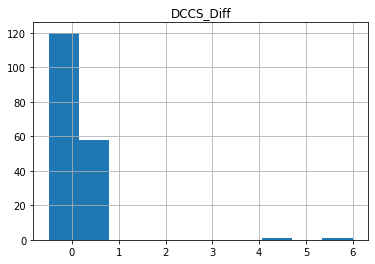

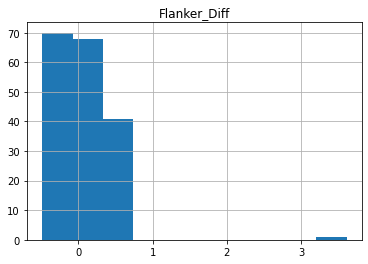

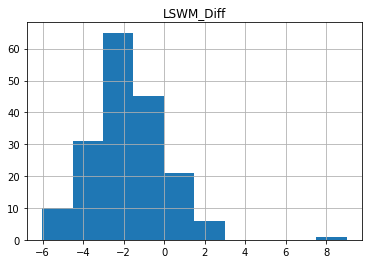

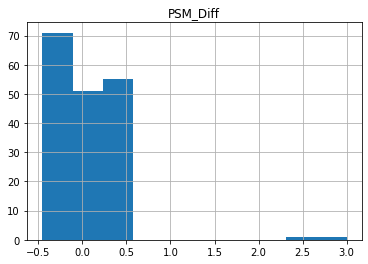

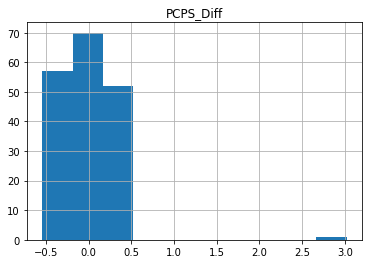

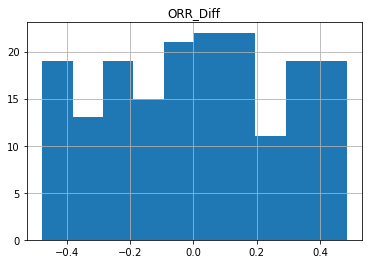

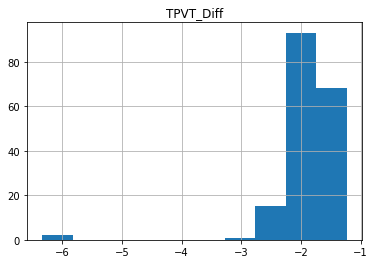

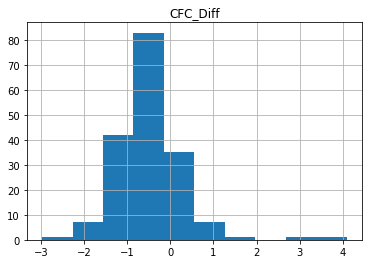

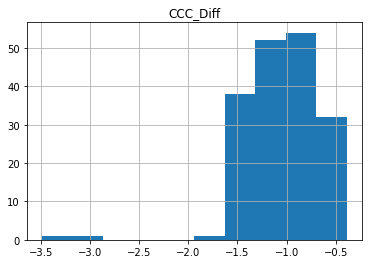

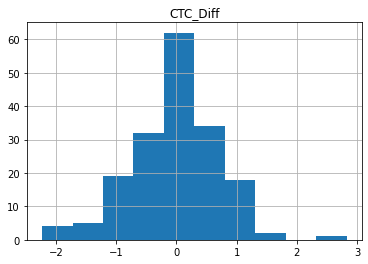

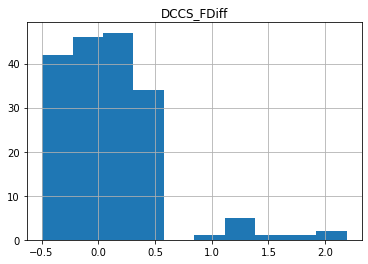

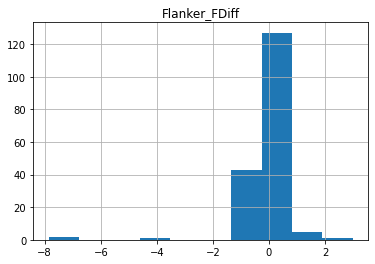

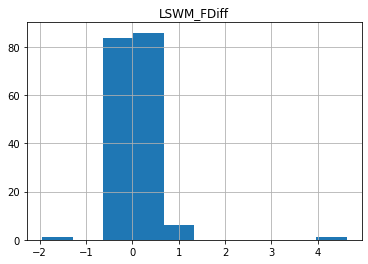

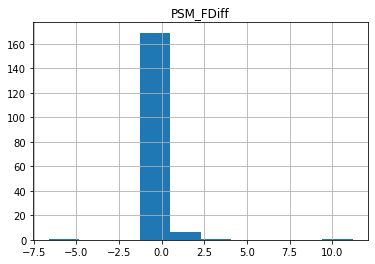

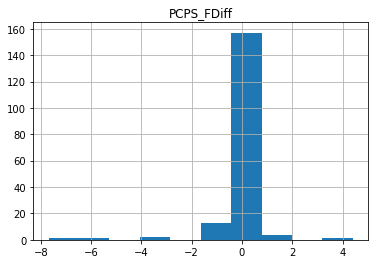

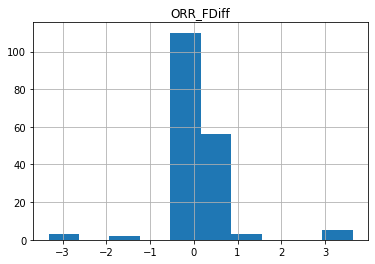

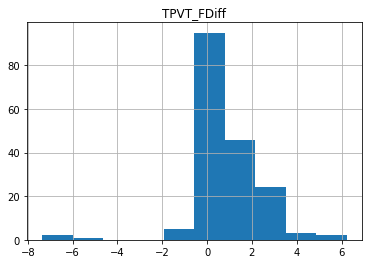

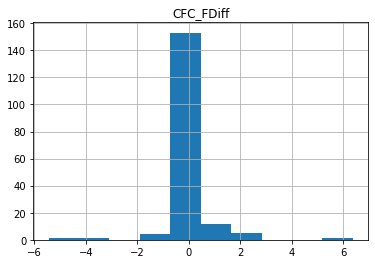

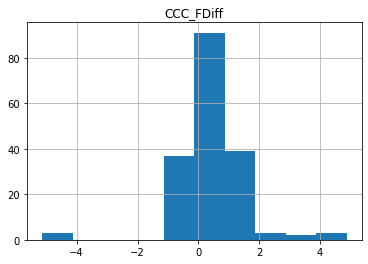

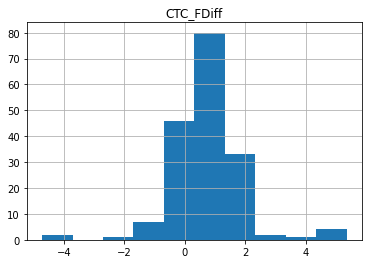

In [298]:
for diff in cd:
    genpop.hist(column=diff)

In [299]:
# calculate the Cohen's d between two samples
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


In [300]:
#Formula from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133225/

def CI95(d1, d2, cohend):
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    ss = (n1+n2)/(n1*n2) + (cohend)*(cohend)/(2*n1+2*n2)
    s = sqrt(ss)
    ci1  = round((cohend-1.96*s),2)
    ci2  = round((cohend+1.96*s),2)
    
    CI = '['+str(ci1) + ', ' + str(ci2)+']'
    return CI
    

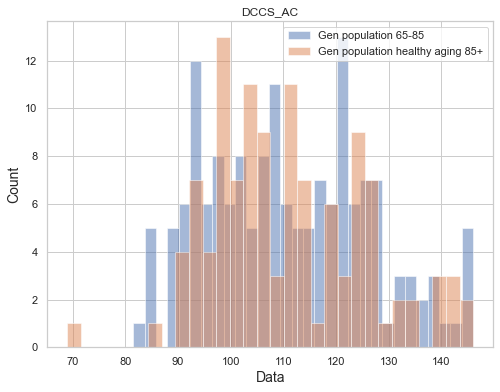

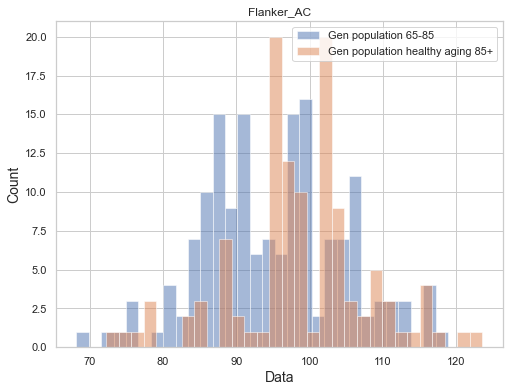

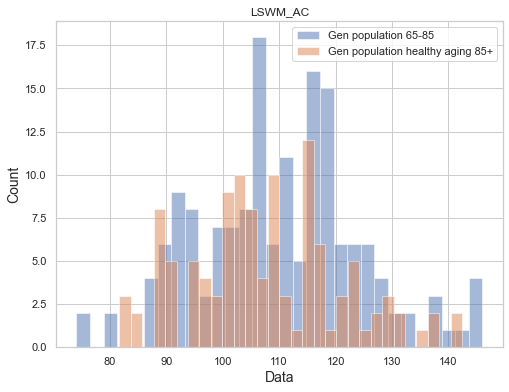

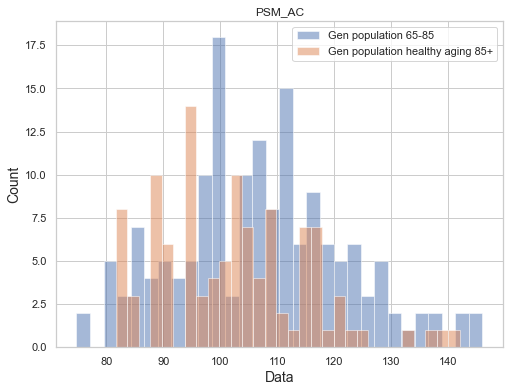

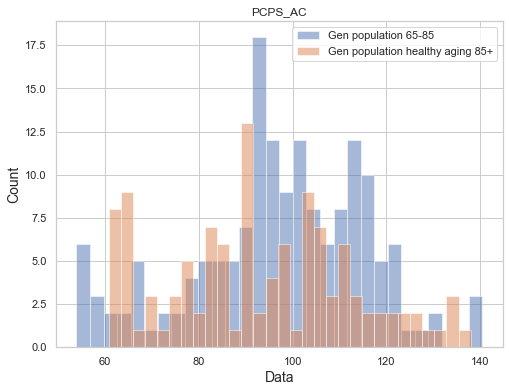

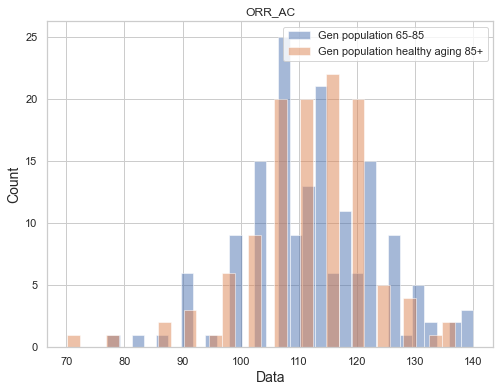

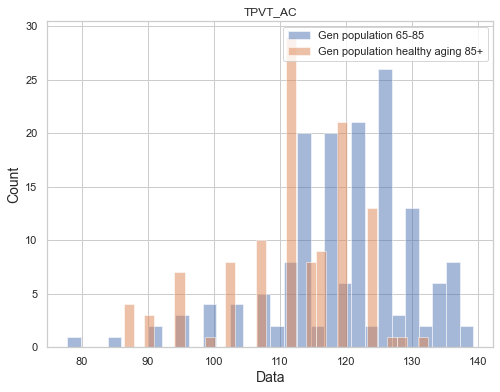

In [301]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[AC], bins=30, alpha=0.5, label='Gen population 65-85')
    plt.hist(g2[AC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(AC)
    plt.legend(loc='upper right')

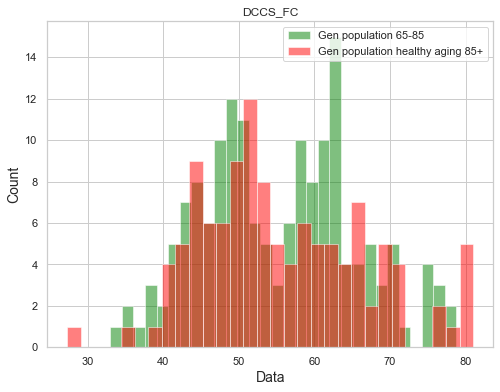

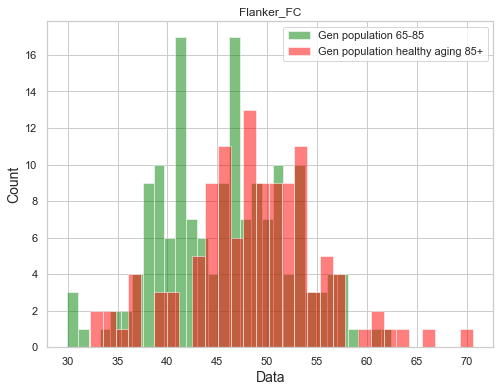

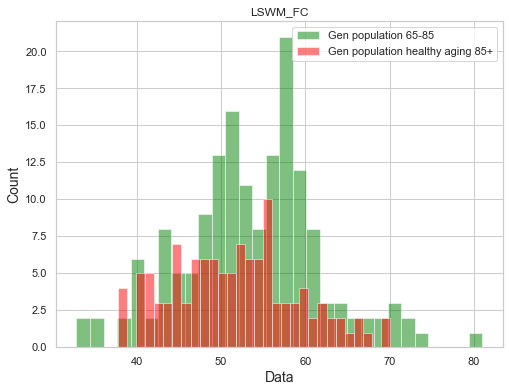

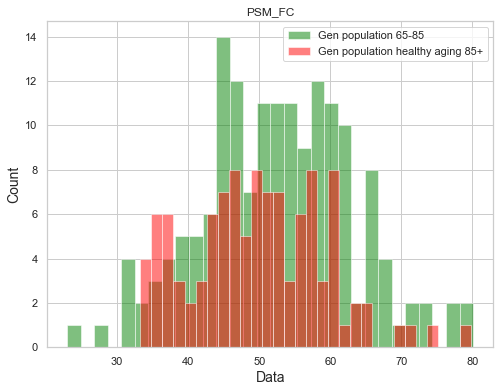

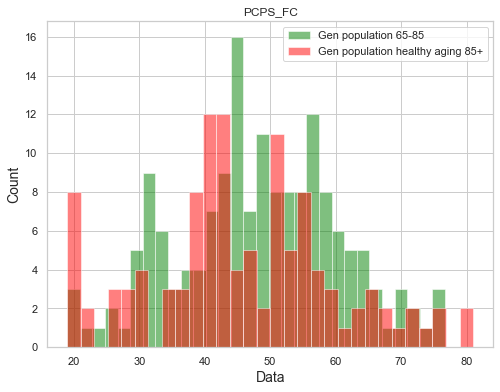

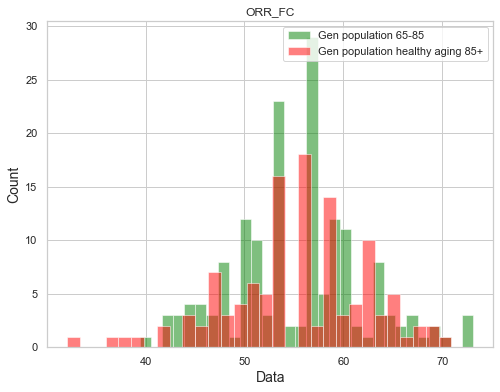

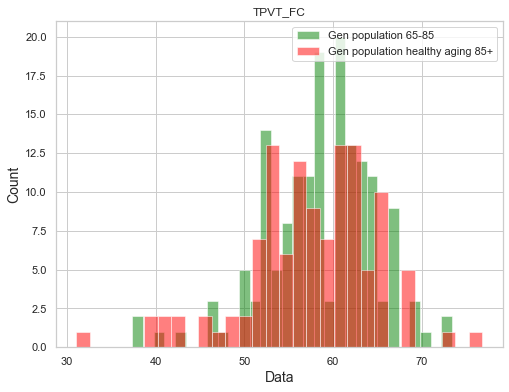

In [302]:
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[FC], bins=30, alpha=0.5, label='Gen population 65-85' , color='green')
    plt.hist(g2[FC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+', color='red')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(FC)
    plt.legend(loc='upper right')

# 5. Plot the scores where the x-axis is age and the y-axis is the type of score. There will be three plots: one for uncorrected, age-corrected, and fully-corrected. Within each of these plots will have 10 subplots (for the seven cognition scores and three composites).



In [303]:
import statsmodels.api as sm # import statsmodels 
from sklearn import linear_model

def ols(y, df):
    dt =df[['AGE', y]].dropna()
    X = dt['AGE'] ## X usually means our input variables (or independent variables)
    y = dt[y] ## Y usually means our output/dependent variable
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
               
    # Print out the statistics
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          DCCS_UCSScore   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     57.42
Date:                Mon, 24 Jan 2022   Prob (F-statistic):           5.30e-13
Time:                        17:25:51   Log-Likelihood:                -1008.6
No. Observations:                 279   AIC:                             2021.
Df Residuals:                     277   BIC:                             2029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.8962      4.980     27.086      0.0

                            OLS Regression Results                            
Dep. Variable:             Flanker_FC   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     6.817
Date:                Mon, 24 Jan 2022   Prob (F-statistic):            0.00952
Time:                        17:25:53   Log-Likelihood:                -922.93
No. Observations:                 278   AIC:                             1850.
Df Residuals:                     276   BIC:                             1857.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.2939      3.711     10.049      0.0

                            OLS Regression Results                            
Dep. Variable:                 PSM_AC   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     9.444
Date:                Mon, 24 Jan 2022   Prob (F-statistic):            0.00234
Time:                        17:25:55   Log-Likelihood:                -1102.3
No. Observations:                 271   AIC:                             2209.
Df Residuals:                     269   BIC:                             2216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        129.4581      8.007     16.168      0.0

                            OLS Regression Results                            
Dep. Variable:           ORR_UCSScore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1624
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.687
Time:                        17:25:58   Log-Likelihood:                -880.96
No. Observations:                 279   AIC:                             1766.
Df Residuals:                     277   BIC:                             1773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.6406      3.151     35.109      0.0

                            OLS Regression Results                            
Dep. Variable:                TPVT_FC   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.332
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.249
Time:                        17:26:00   Log-Likelihood:                -915.50
No. Observations:                 277   AIC:                             1835.
Df Residuals:                     275   BIC:                             1842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.4018      3.666     17.023      0.0

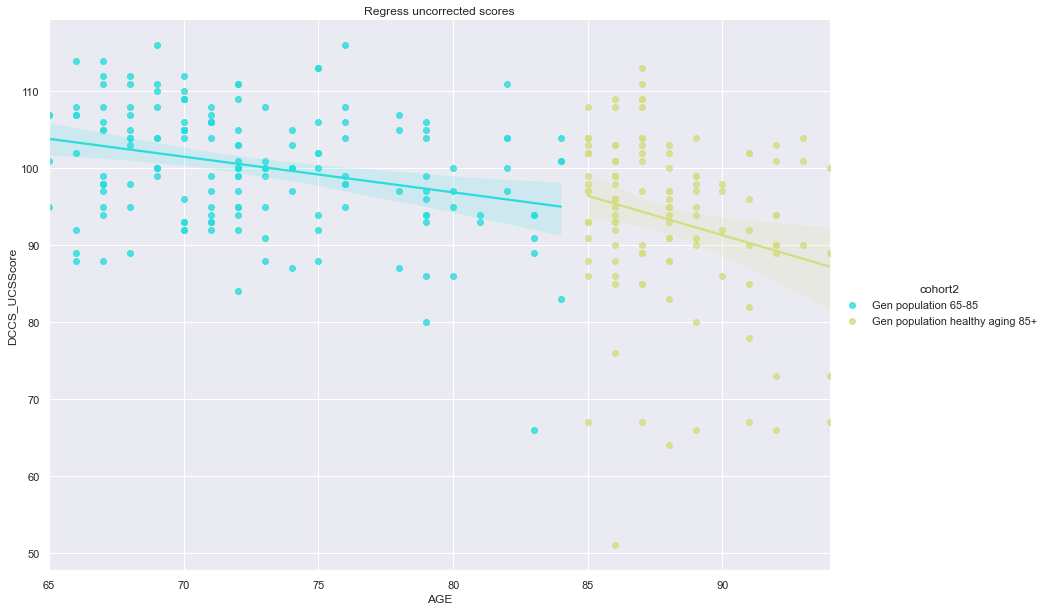

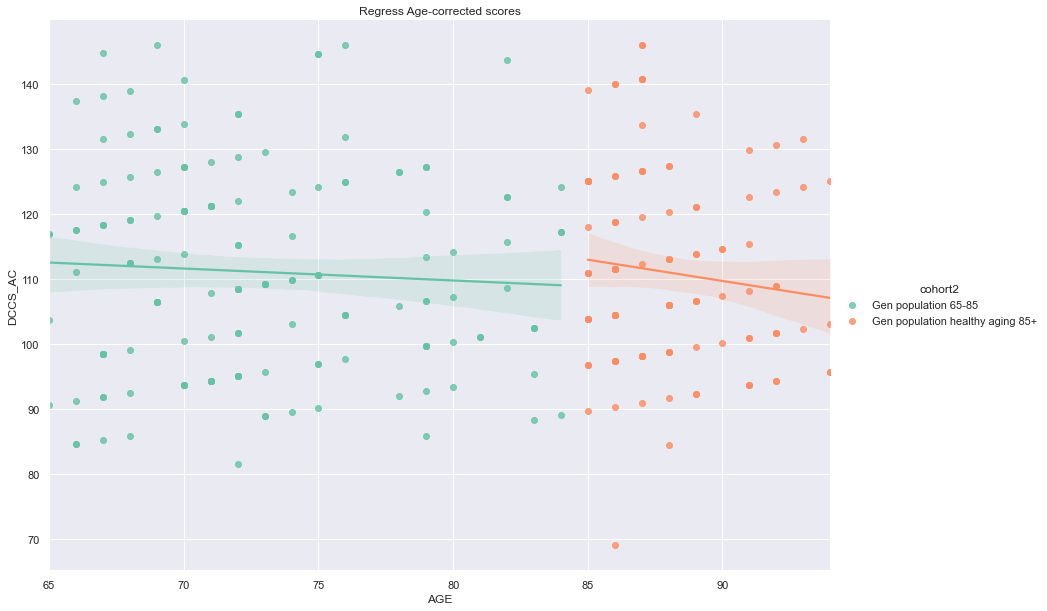

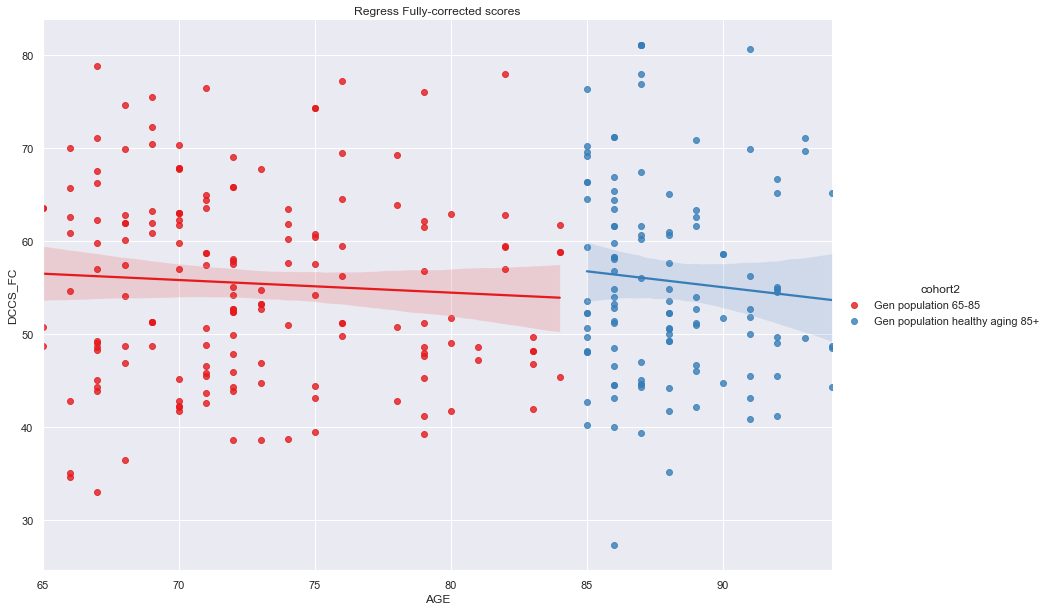

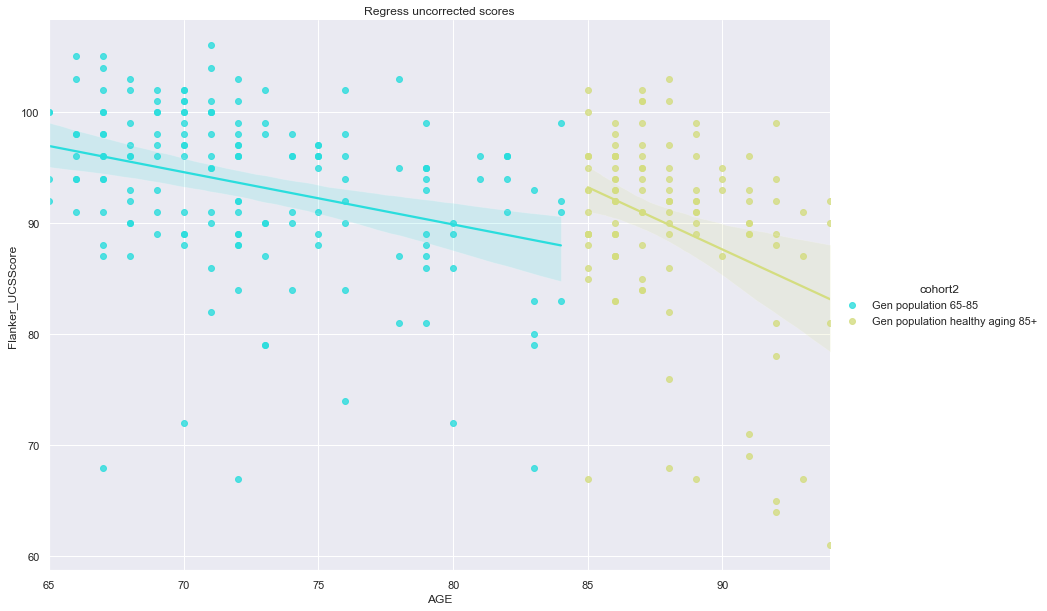

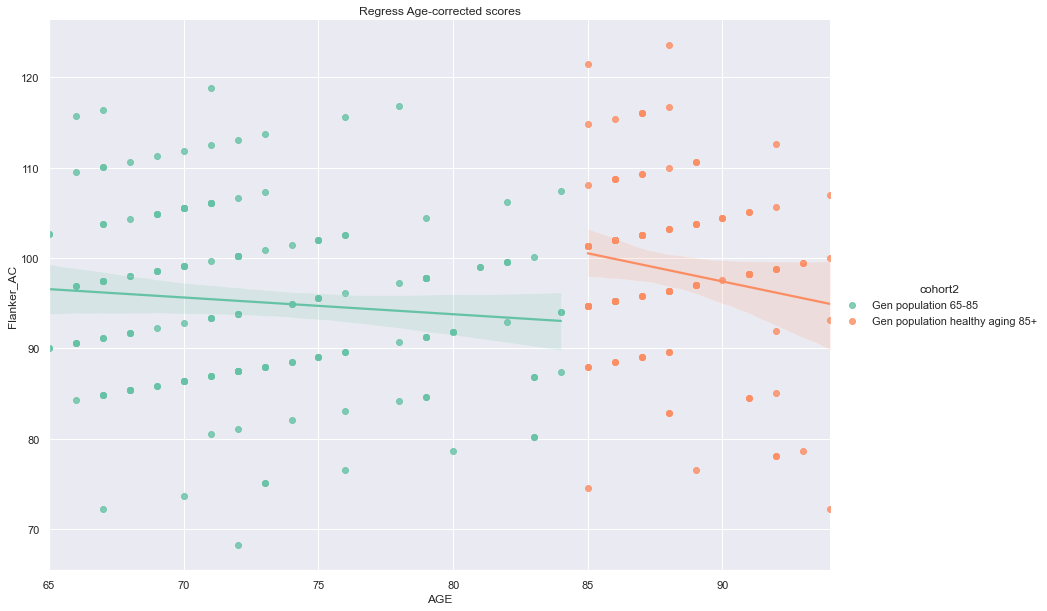

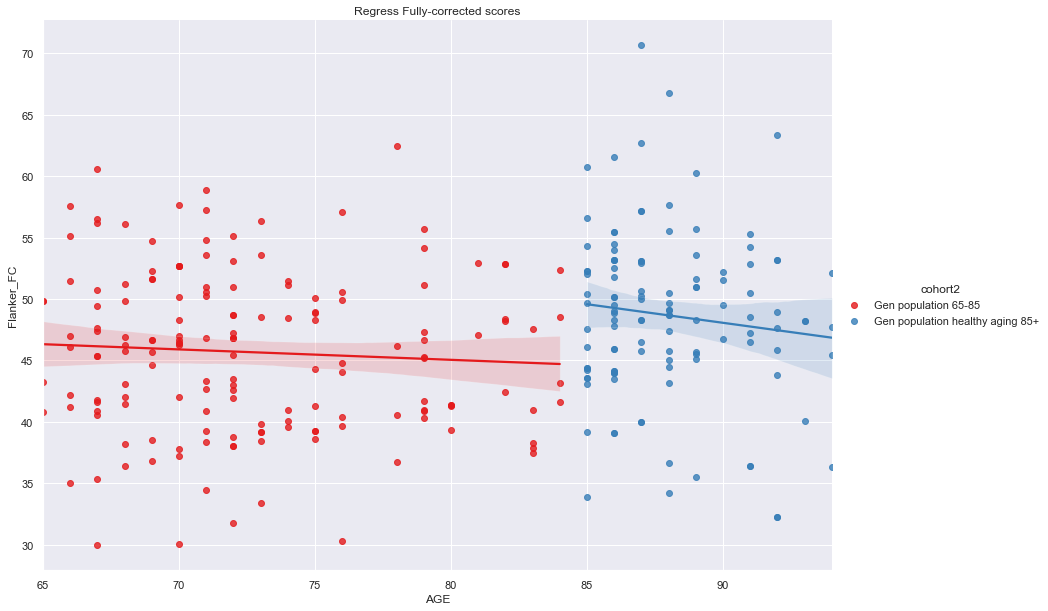

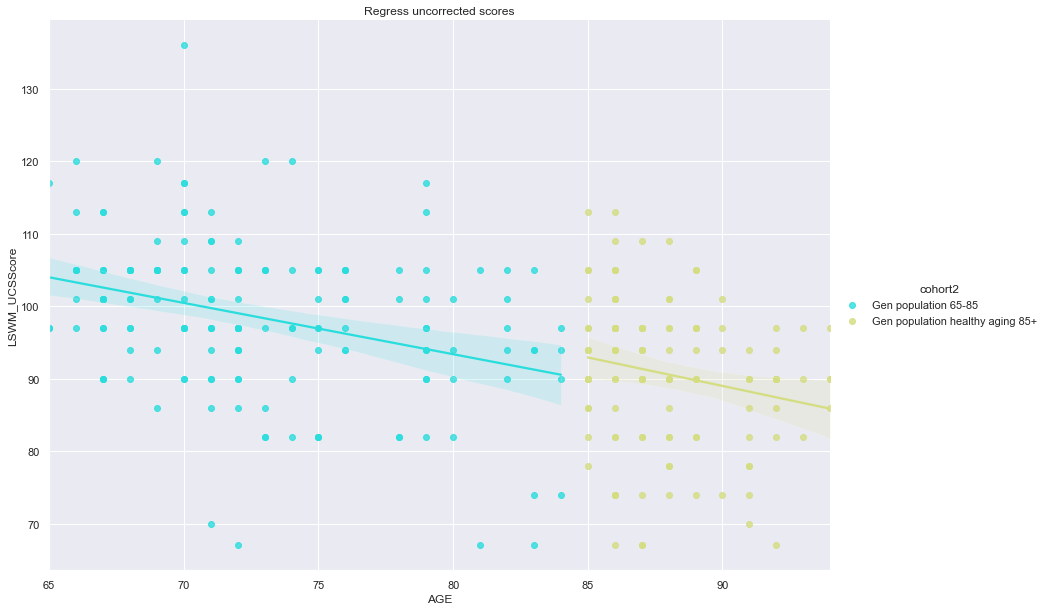

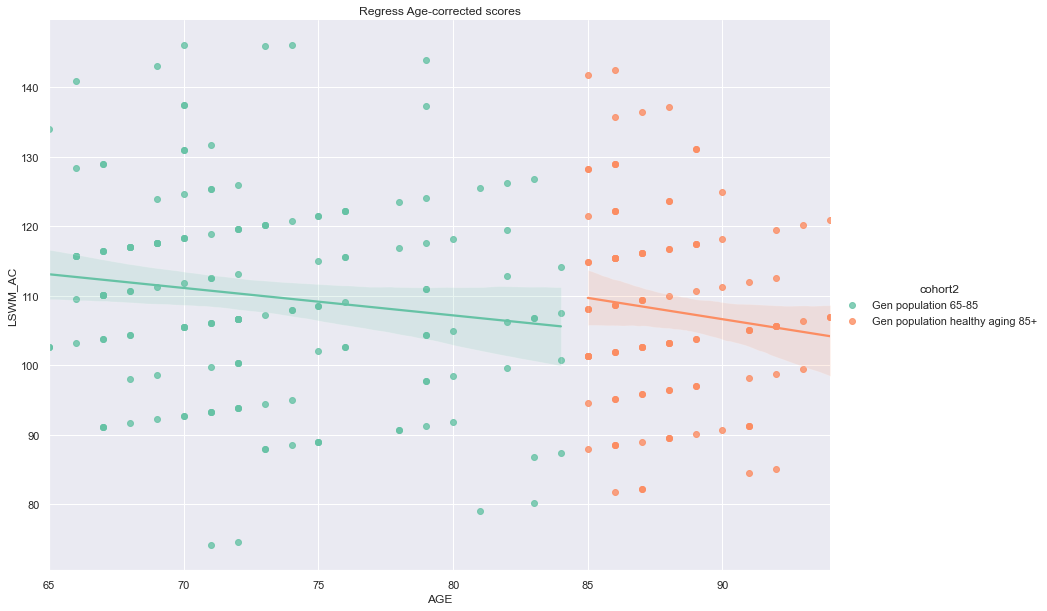

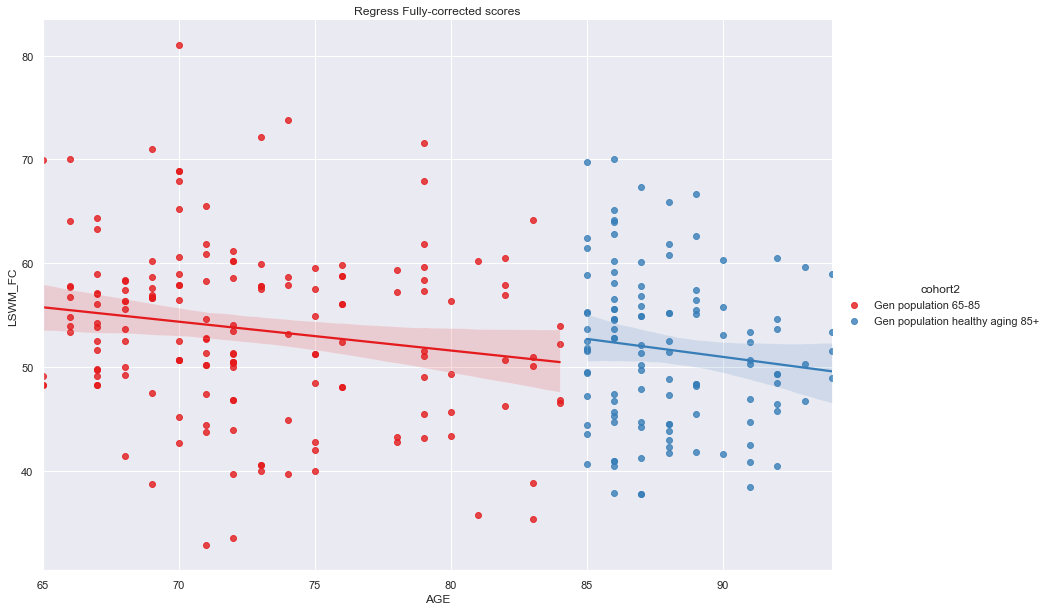

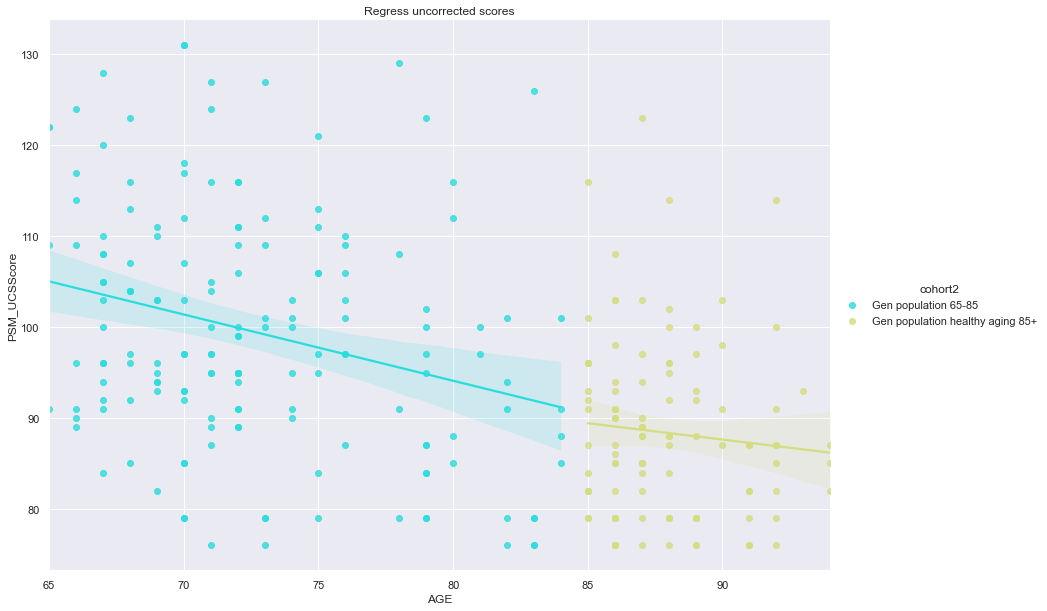

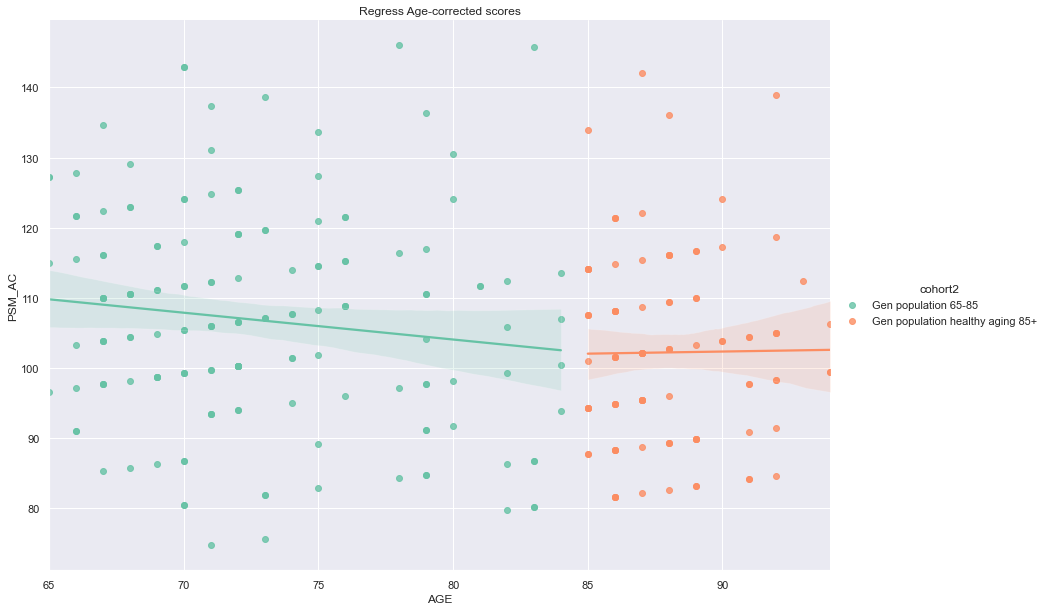

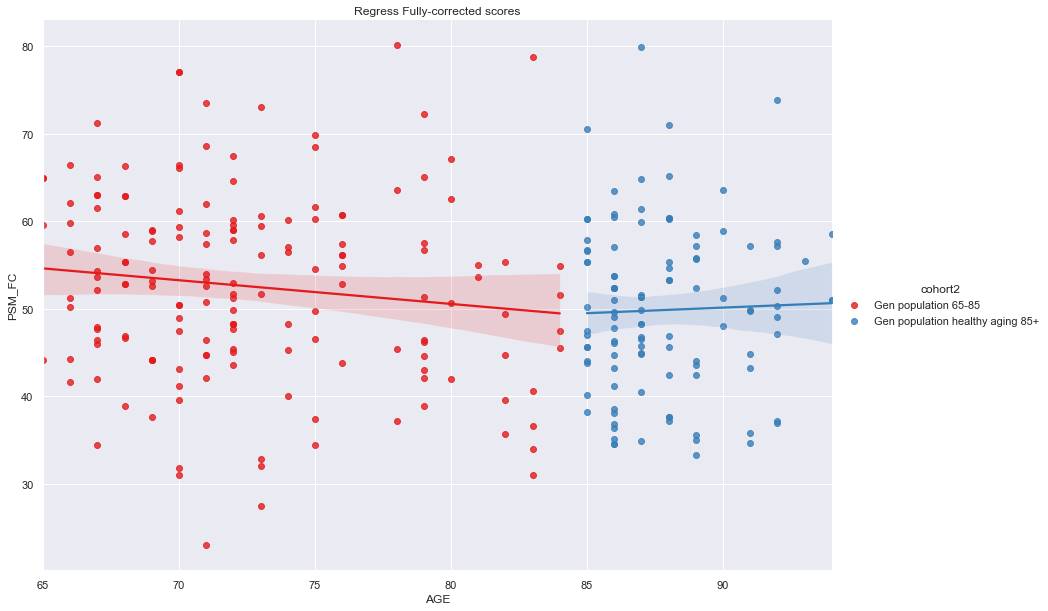

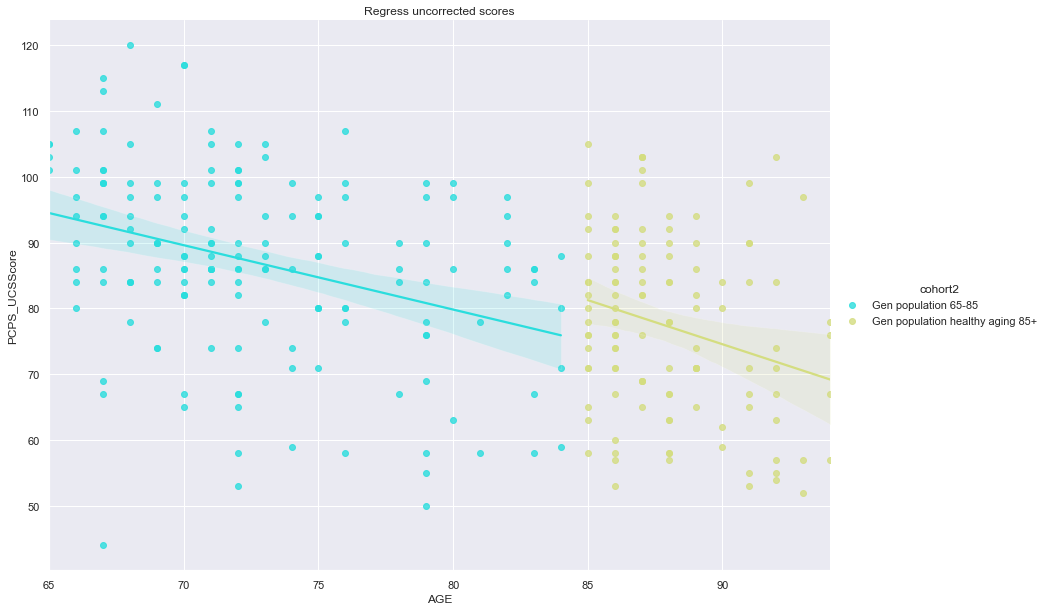

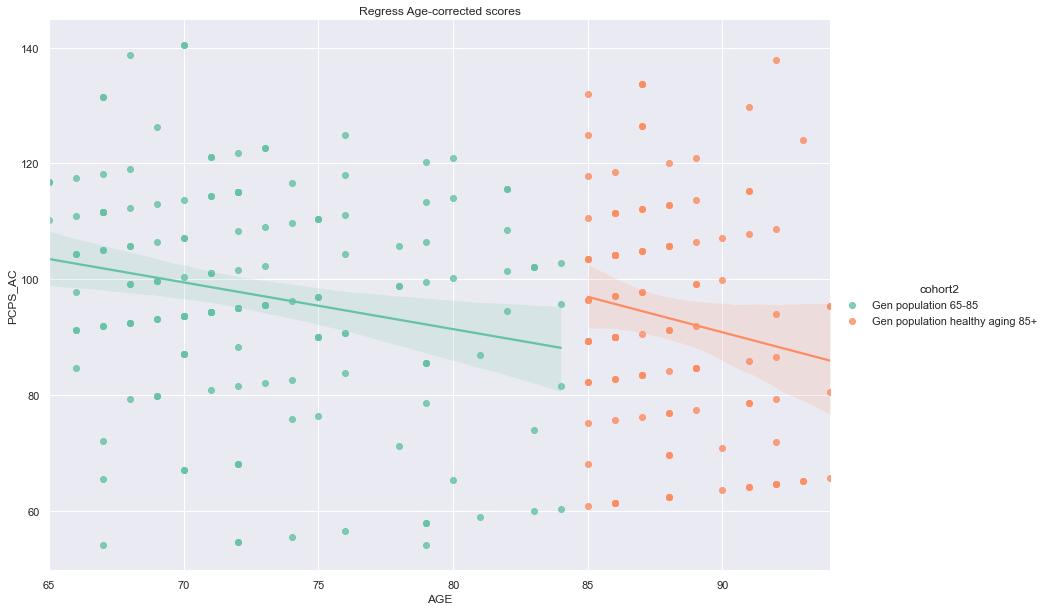

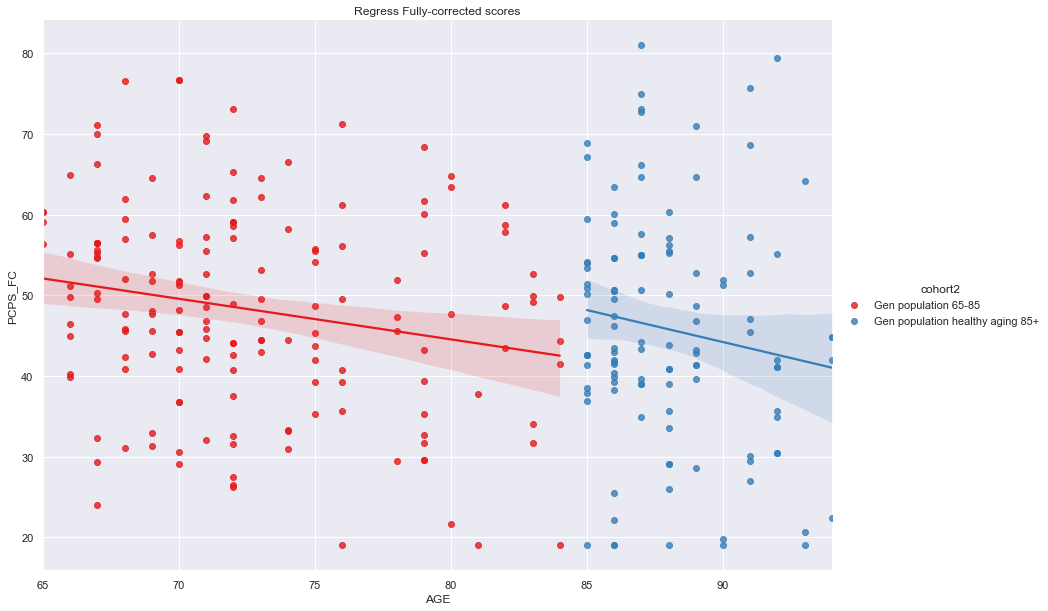

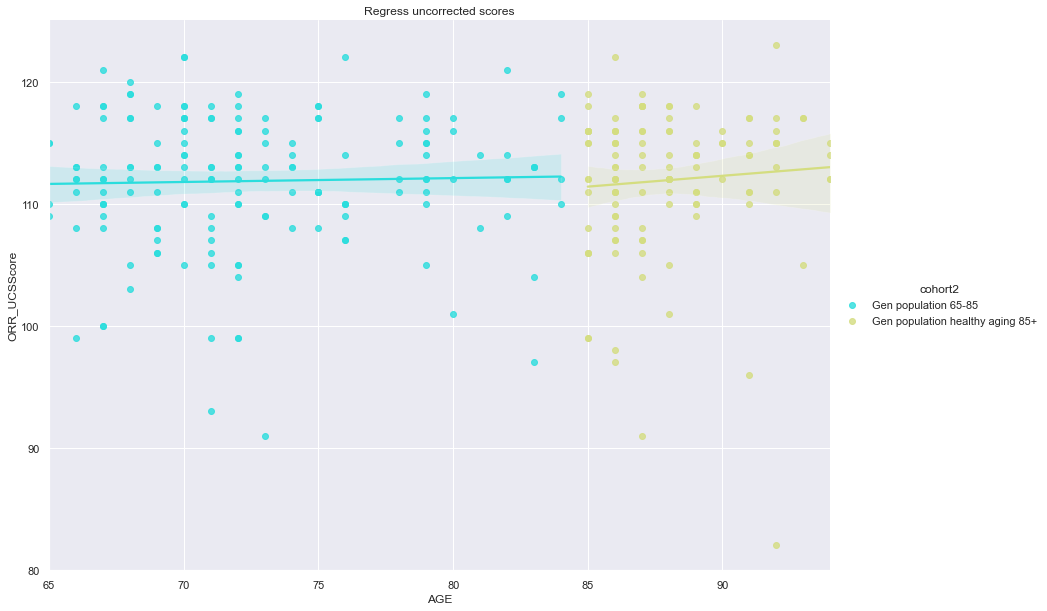

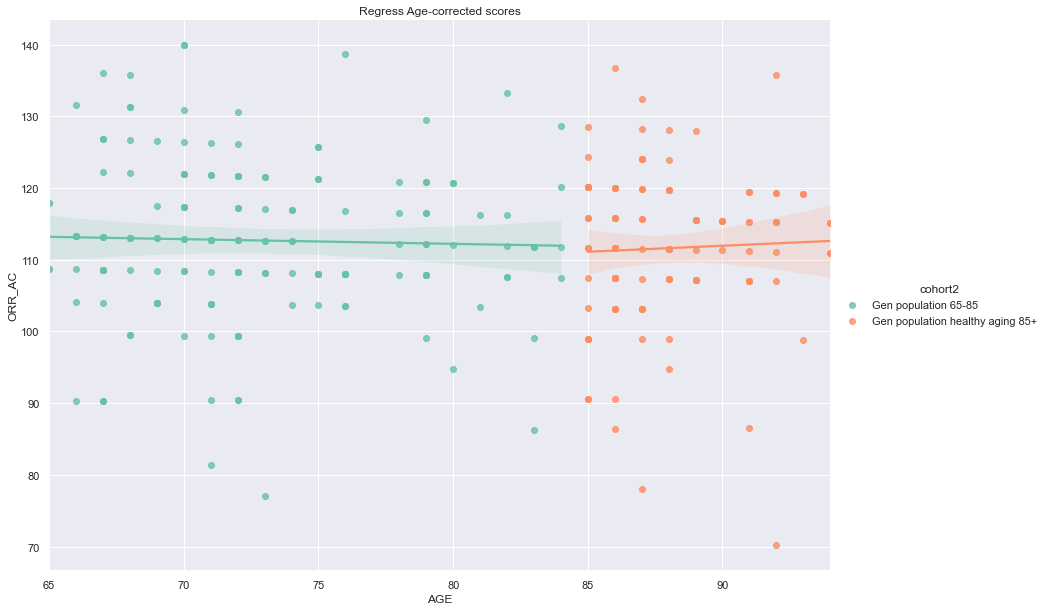

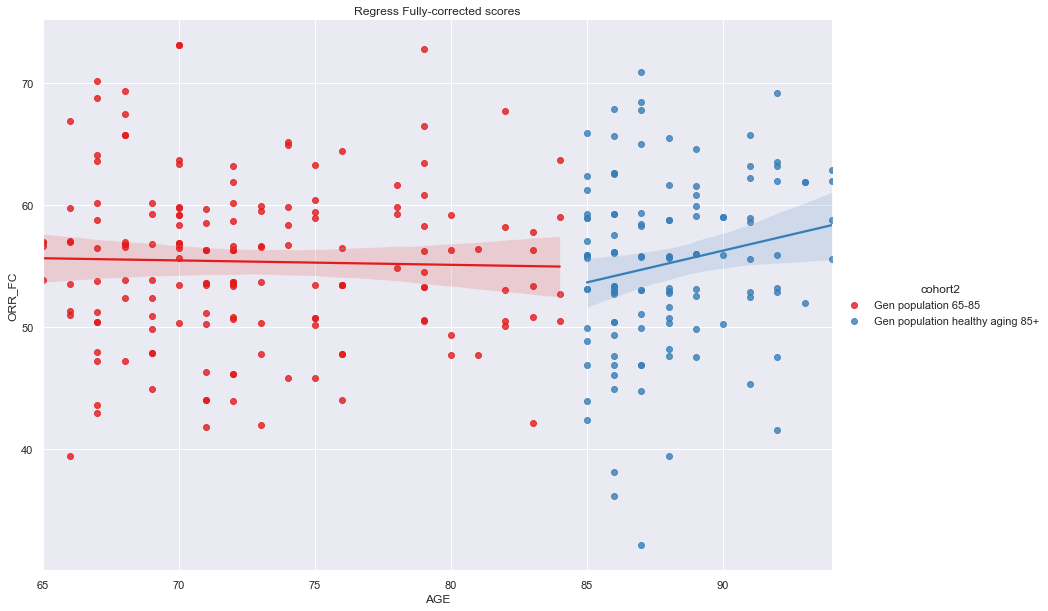

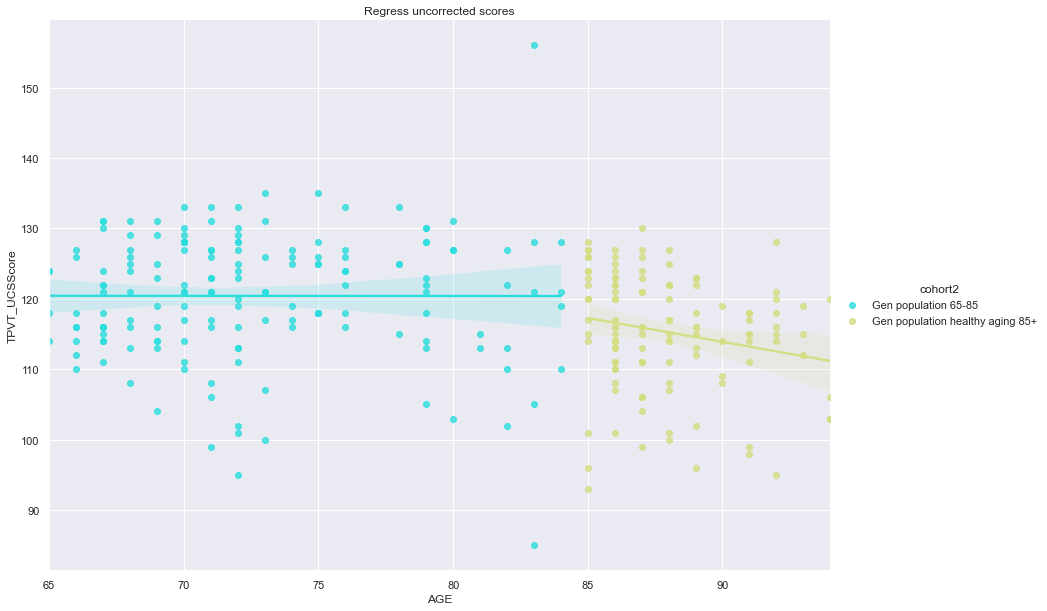

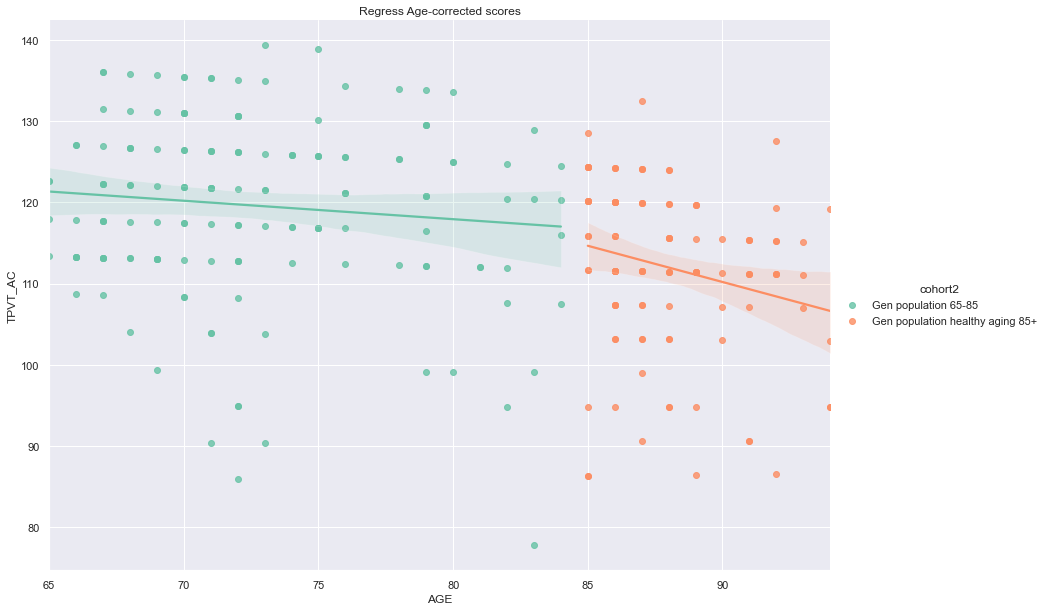

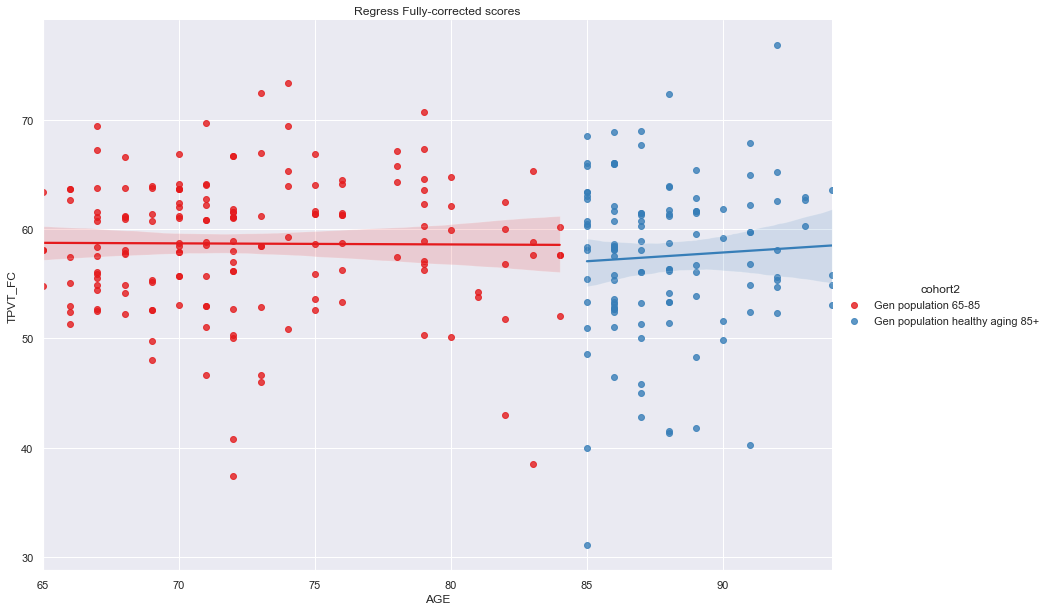

In [593]:
sns.set(style="darkgrid")
for col in measures:
    UC = col+'_UCSScore'
    ols(UC, genpop)
    g = sns.lmplot(x="AGE", y=UC,hue="cohort2", data=genpop, palette='rainbow',height=8.27, aspect=11.7/8.27)
    plt.title('Regress uncorrected scores')
    

    AC = col+'_AC'
    ols(AC, genpop)
    g = sns.lmplot(x="AGE", y=AC,hue="cohort2", data=genpop, palette="Set2",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Age-corrected scores')

    FC = col+'_FC'
    ols(FC, genpop)
    g = sns.lmplot(x="AGE", y=FC,hue="cohort2", data=genpop, palette="Set1",height=8.27, aspect=11.7/8.27)
    plt.title('Regress Fully-corrected scores')

In [306]:
genpop

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,ORR_AC,ORR_Diff,TPVT_AC,TPVT_Diff,CFC_AC,CFC_Diff,CCC_AC,CCC_Diff,CTC_AC,CTC_Diff
13,1.50313,1,Emory,Gen population 65-85,en-US,68,2,1,2,0,...,99.45,-0.45,103.99,-1.99,93.75,-0.75,101.69,-0.69,97.29,-1.29
17,1.52966,1,Emory,Gen population 65-85,en-US,74,1,1,2,0,...,112.56,0.44,125.84,-1.84,86.56,-0.56,120.91,-0.91,103.91,-0.91
19,1.53368,1,Emory,Gen population healthy aging 85+,en-US,91,2,1,2,0,...,111.23,NaN,115.34,NaN,111.39,NaN,114.41,NaN,113.99,NaN
37,1.70772,1,Emory,Gen population healthy aging 85+,en-US,87,1,1,2,0,...,107.34,NaN,98.97,NaN,94.50,NaN,103.27,NaN,98.58,NaN
54,101149735,1,Mayo,Gen population healthy aging 85+,en-US,89,2,1,2,0,...,107.23,NaN,86.48,NaN,96.74,NaN,96.34,NaN,96.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,UM00001612,1,UMich,Gen population 65-85,en-US,69,2,1,1,1,...,103.94,0.06,112.99,-1.99,96.51,-0.51,109.11,-1.11,102.89,0.11
825,UM00001616,1,UMich,Gen population 65-85,en-US,71,1,1,1,1,...,112.82,0.18,135.24,-1.24,106.18,-0.18,126.23,-1.23,117.62,0.38
829,UM00001652,1,UMich,Gen population 65-85,en-US,76,2,1,1,1,...,108.01,-0.01,121.17,-2.17,106.51,-0.51,115.84,-0.84,112.09,-0.09
834,UM00001679,1,UMich,Gen population 65-85,en-US,83,2,1,1,1,...,111.83,0.17,120.34,-1.34,93.32,0.68,117.49,-0.49,105.75,0.25


In [31]:
# Install pymer4
!pip install -q pymer4
# load pymer4
from pymer4.models import Lmer
!apt-get install r-base
!pip install -q rpy2
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

data = sm.datasets.get_rdataset('dietox', 'geepack').data
model = Lmer('Weight ~ Time + Evit + (1 + Time|Pig)', data=data)


PackageNotInstalledError: The R package "lmerTest" is not installed.

In [327]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

def compare_reg(score, df):
    # Note the difference in argument order
    
    dt =df[['AGE', score]].dropna()
    dt["Intercept"] = 1 ## let's add an intercept (beta_0) to our model
    X = dt[['AGE','Intercept']] ## X usually means our input variables (or independent variables)
    y = dt[score] ## Y usually means our output/dependent variable
 
    model = sm.OLS(y, X).fit()
    # Print out the statistic
    print(model.summary())
    print('')

    test =df[[score, "AGE", 'site']].dropna()
    formula = score+'~ AGE'
    md = smf.mixedlm(formula, test, groups=test["site"], re_formula="~AGE")
    model2 = md.fit(method=["lbfgs"])
    print(model2.summary())
    print('')
    
    test =genpop[['AGE', score, 'EDUCATION','MALE','race_tb_rc','site']].dropna()
    endog = test[score]
    test["Intercept"] = 1
    exog = test[["Intercept","AGE", 'EDUCATION','MALE','race_tb_rc']]
    exog_re = exog.copy()

    md = sm.MixedLM(endog, exog, test["site"], exog_re)
    model3 = md.fit()
    print(model2.summary())

    

In [329]:
UCC=[]
for col in measures:
    UC = col+'_UCSScore'
    UCC.append(UC)
    print(UC)
    compare_reg(UC, genpop)

DCCS_UCSScore
                            OLS Regression Results                            
Dep. Variable:          DCCS_UCSScore   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     57.42
Date:                Thu, 27 Jan 2022   Prob (F-statistic):           5.30e-13
Time:                        11:54:48   Log-Likelihood:                -1008.6
No. Observations:                 279   AIC:                             2021.
Df Residuals:                     277   BIC:                             2029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.4743      0.063     -

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: LSWM_UCSScore
No. Observations:   277     Method:             REML         
No. Groups:         8       Scale:              98.3298      
Min. group size:    9       Log-Likelihood:     -1032.7517   
Max. group size:    92      Converged:          No           
Mean group size:    34.6                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       140.647    6.458 21.777 0.000 127.988 153.305
AGE              -0.577    0.087 -6.667 0.000  -0.747  -0.407
Group Var        74.046                                      
Group x AGE Cov  -1.155                                      
AGE Var           0.018                                      


            Mixed Linear Model Regression Results
Model:              MixedLM De

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: PCPS_UCSScore
No. Observations:   278     Method:             REML         
No. Groups:         8       Scale:              174.0699     
Min. group size:    9       Log-Likelihood:     -1113.8610   
Max. group size:    93      Converged:          Yes          
Mean group size:    34.8                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       142.437   11.399 12.495 0.000 120.095 164.780
AGE              -0.751    0.136 -5.538 0.000  -1.017  -0.485
Group Var       138.825                                      
Group x AGE Cov  -1.375                                      
AGE Var           0.014                                      

ORR_UCSScore
                            OLS Regression Results                  

In [332]:
uc_over85 = genpop[['AGE', 'EDUCATION','MALE','race_tb_rc','site','DCCS_UCSScore',
 'Flanker_UCSScore',
 'LSWM_UCSScore',
 'PSM_UCSScore',
 'PCPS_UCSScore',
 'ORR_UCSScore',
 'TPVT_UCSScore']]

In [333]:
uc_over85.to_csv('C:/Users/tsb7592/Downloads/uc_over85.csv', index=False)

In [371]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def compare_ols(score, df):
    # Note the difference in argument order
    test =df[['AGE', score, 'EDUCATION','MALE','race_tb_rc','site']].dropna()
    formula = score+'~ AGE'
    md1= ols(formula, data=test).fit()
    #display(md1.summary())
    
    formula2 = score+'~ AGE+site'
    md2= ols(formula2, data=test).fit()
    #display(md2.summary())


    formula3 = score+'~ AGE+EDUCATION+MALE+race_tb_rc+site'
    md3= ols(formula3, data=test).fit()
    #display(md3.summary())
    
    rr=anova_lm(md1,md2)
    rr.index=[1,2]
    display(rr)
    rr2=anova_lm(md1,md3)
    rr2.index=[1,3]
    display(rr2)
    rr3=anova_lm(md2,md3)
    rr3.index=[2,3]
    display(rr3)
    print("")

In [372]:
for col in measures:
    UC = col+'_UCSScore'
    print(UC)
    compare_ols(UC, genpop)

DCCS_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,277.00,22555.94,0.00,NaN,NaN,NaN
2,270.00,21393.03,7.00,1162.91,2.10,0.04


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,277.00,22555.94,0.00,NaN,NaN,NaN
3,267.00,20759.78,10.00,1796.15,2.31,0.01


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,270.00,21393.03,0.00,NaN,NaN,NaN
3,267.00,20759.78,3.00,633.24,2.71,0.05



Flanker_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,15909.11,0.00,NaN,NaN,NaN
2,269.00,15316.97,7.00,592.14,1.49,0.17


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,15909.11,0.00,NaN,NaN,NaN
3,266.00,14889.10,10.00,1020.02,1.82,0.06


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,269.00,15316.97,0.00,NaN,NaN,NaN
3,266.00,14889.10,3.00,427.88,2.55,0.06



LSWM_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,275.00,27821.30,0.00,NaN,NaN,NaN
2,268.00,26390.30,7.00,1430.99,2.08,0.05


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,275.00,27821.30,0.00,NaN,NaN,NaN
3,265.00,25715.67,10.00,2105.63,2.17,0.02


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,268.00,26390.30,0.00,NaN,NaN,NaN
3,265.00,25715.67,3.00,674.64,2.32,0.08



PSM_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,269.00,35935.06,0.00,NaN,NaN,NaN
2,262.00,33738.71,7.00,2196.35,2.44,0.02


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,269.00,35935.06,0.00,NaN,NaN,NaN
3,259.00,32602.55,10.00,3332.51,2.65,0.00


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,262.00,33738.71,0.00,NaN,NaN,NaN
3,259.00,32602.55,3.00,1136.15,3.01,0.03



PCPS_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,48874.54,0.00,NaN,NaN,NaN
2,269.00,47035.78,7.00,1838.76,1.50,0.17


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,48874.54,0.00,NaN,NaN,NaN
3,266.00,46499.74,10.00,2374.80,1.36,0.20


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,269.00,47035.78,0.00,NaN,NaN,NaN
3,266.00,46499.74,3.00,536.04,1.02,0.38



ORR_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,277.00,9031.09,0.00,NaN,NaN,NaN
2,270.00,8006.30,7.00,1024.79,4.94,0.00


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,277.00,9031.09,0.00,NaN,NaN,NaN
3,267.00,6665.86,10.00,2365.24,9.47,0.00


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,270.00,8006.30,0.00,NaN,NaN,NaN
3,267.00,6665.86,3.00,1340.44,17.90,0.00



TPVT_UCSScore


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,21236.91,0.00,NaN,NaN,NaN
2,269.00,19042.00,7.00,2194.91,4.43,0.00


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,276.00,21236.91,0.00,NaN,NaN,NaN
3,266.00,16925.61,10.00,4311.31,6.78,0.00


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,269.00,19042.00,0.00,NaN,NaN,NaN
3,266.00,16925.61,3.00,2116.40,11.09,0.00


In [271]:
import numpy as np
import scipy.stats as stats
print("Aged-corrected")
for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][AC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][AC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")

Aged-corrected
DCCS t-stat =   0.05, pvalue =   0.96
Cohens d: 0.007 ( Gen population 65-85 vs Gen population healthy aging 85+ )
Flanker t-stat =  -3.04, pvalue =   0.00
Cohens d: -0.368 ( Gen population 65-85 vs Gen population healthy aging 85+ )
LSWM t-stat =   1.30, pvalue =   0.19
Cohens d: 0.157 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PSM t-stat =   2.70, pvalue =   0.01
Cohens d: 0.326 ( Gen population 65-85 vs Gen population healthy aging 85+ )
PCPS t-stat =   1.69, pvalue =   0.09
Cohens d: 0.208 ( Gen population 65-85 vs Gen population healthy aging 85+ )
ORR t-stat =   0.83, pvalue =   0.41
Cohens d: 0.100 ( Gen population 65-85 vs Gen population healthy aging 85+ )
TPVT t-stat =   6.01, pvalue =   0.00
Cohens d: 0.722 ( Gen population 65-85 vs Gen population healthy aging 85+ )


Small Effect Size: d=0.20
Medium Effect Size: d=0.50
Large Effect Size: d=0.80

In [272]:
print("Fully-corrected")
for col in measures:
    FC = col+'_FC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][FC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][FC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    # calculate cohen's d
    d = cohend(g1, g2)
    print('Cohens d: %.3f (' % d,'Gen population 65-85 vs Gen population healthy aging 85+', ")")
    print('')

Fully-corrected
DCCS t-stat =  -0.22, pvalue =   0.83
Cohens d: -0.026 ( Gen population 65-85 vs Gen population healthy aging 85+ )

Flanker t-stat =  -3.69, pvalue =   0.00
Cohens d: -0.452 ( Gen population 65-85 vs Gen population healthy aging 85+ )

LSWM t-stat =   2.05, pvalue =   0.04
Cohens d: 0.246 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PSM t-stat =   2.16, pvalue =   0.03
Cohens d: 0.262 ( Gen population 65-85 vs Gen population healthy aging 85+ )

PCPS t-stat =   1.47, pvalue =   0.14
Cohens d: 0.183 ( Gen population 65-85 vs Gen population healthy aging 85+ )

ORR t-stat =   0.18, pvalue =   0.86
Cohens d: 0.022 ( Gen population 65-85 vs Gen population healthy aging 85+ )

TPVT t-stat =   1.37, pvalue =   0.17
Cohens d: 0.172 ( Gen population 65-85 vs Gen population healthy aging 85+ )



In [273]:
genpop[select].round(2).to_csv('C:/Users/tsb7592/Downloads/age_corrected_data.csv', index=False)

In [274]:
genpop[genpop.AGE <= 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,180.00,180.00,180.00
mean,73.92,0.35,16.94
std,6.07,0.48,2.14
min,65.00,0.00,8.00
25%,69.00,0.00,16.00
50%,72.00,0.00,18.00
75%,79.00,1.00,18.00
max,85.00,1.00,20.00


In [275]:
genpop[genpop.AGE<= 85]['MARISTAT'].value_counts()

Married                                      56
Divorced                                     24
Widowed                                      21
Never married (or marriage was annulled)      3
Living as married/domestic partner            2
Name: MARISTAT, dtype: int64

In [276]:
# for the below 85 group and above 85 group: age (mean and sd), education level, race/ethnicity, gender, marital status

genpop[genpop.AGE > 85][['AGE','MALE','EDUCATION']].describe()

,AGE,MALE,EDUCATION
count,100.00,100.00,100.00
mean,88.55,0.48,16.42
std,2.40,0.50,2.94
min,86.00,0.00,7.00
25%,86.00,0.00,15.50
50%,88.00,0.00,16.00
75%,91.00,1.00,18.00
max,94.00,1.00,20.00


In [277]:
genpop[genpop.AGE> 85]['MARISTAT'].value_counts()

Married                                      20
Widowed                                      15
Never married (or marriage was annulled)      5
Divorced                                      5
Name: MARISTAT, dtype: int64

In [279]:
genpop[genpop.AGE> 85]['race'].value_counts()

White                        91
Black or African American     8
Asian                         1
Name: race, dtype: int64

In [280]:
genpop.EDUCATION.describe()

count   280.00
mean     16.76
std       2.46
min       7.00
25%      16.00
50%      18.00
75%      18.00
max      20.00
Name: EDUCATION, dtype: float64

In [281]:
table = pd.DataFrame(columns=('<85', '>=85'))

for col in genpop.columns:
    if 'UCS' in col:
        avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
        st = round(genpop[genpop.AGE<85][col].std(), 2)
        val = str(avg) + '('+str(st)+')'
        avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
        st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
        val1 = str(avg1) + '('+str(st1)+')'
        ind = col.split('_')[0]
        table.loc[ind] = [val, val1]

In [282]:
table

,<85,>=85
CCC,116.88(7.18),114.11(6.84)
CFC,92.77(10.21),82.57(9.67)
CTC,105.11(8.36),97.92(7.68)
DCCS,100.27(7.81),93.38(11.05)
Flanker,93.31(7.42),89.87(8.45)
LSWM,98.54(10.65),90.56(10.24)
ORR,111.88(5.48),111.94(6.02)
PCPS,86.98(14.22),77.24(13.51)
PSM,99.43(13.24),88.41(9.57)
TPVT,120.42(9.04),115.28(8.31)


In [283]:
ACcol= ['DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC']

In [284]:
table1 = pd.DataFrame(columns=('<85_AC', '>=85_AC'))

for col in ACcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table1.loc[ind] = [val, val1]

In [285]:
table1

,<85_AC,>=85_AC
DCCS,111.12(15.39),111.02(14.63)
Flanker,95.13(9.73),98.66(9.41)
LSWM,110.05(14.46),107.85(13.55)
PSM,106.86(15.03),102.22(13.0)
PCPS,97.26(18.66),93.26(19.92)
ORR,112.71(10.94),111.62(10.55)
TPVT,119.59(10.83),112.02(9.99)
CFC,105.85(14.23),104.55(13.67)
CCC,117.56(11.07),112.69(10.01)
CTC,112.68(11.29),109.83(10.2)


In [286]:
FCcol =['DCCS_FC',
'Flanker_FC',
'LSWM_FC',
'PSM_FC',
'PCPS_FC',
'ORR_FC',
'TPVT_FC',
'CFC_FC',
'CCC_FC',
'CTC_FC']

In [287]:
table2 = pd.DataFrame(columns=('<85_FC', '>=85_FC'))

for col in FCcol:
    avg = round(genpop[genpop.AGE< 85][col].mean(), 2)
    st = round(genpop[genpop.AGE<85][col].std(), 2)
    val = str(avg) + '('+str(st)+')'
    avg1 = round(genpop[genpop.AGE>= 85][col].mean(), 2)
    st1 = round(genpop[genpop.AGE>=85][col].std(), 2)
    val1 = str(avg1) + '('+str(st1)+')'
    ind = col.split('_')[0]
    table2.loc[ind] = [val, val1]

In [288]:
table2

,<85_FC,>=85_FC
DCCS,55.42(10.23),55.7(10.96)
Flanker,45.67(6.5),48.68(6.82)
LSWM,53.62(8.26),51.67(7.5)
PSM,52.52(10.75),49.85(9.42)
PCPS,48.21(12.52),45.79(14.22)
ORR,55.36(6.64),55.21(7.17)
TPVT,58.67(6.09),57.53(7.27)
CFC,51.46(9.05),50.86(9.6)
CCC,57.71(6.25),56.97(7.01)
CTC,55.03(6.36),54.61(7.16)


In [289]:
af = pd.merge(table1, table2, left_index=True, right_index=True)

# 4.Produce a table for means and SDs for these scores. The resulting matrix is 10 rows (i.e., seven cognition scores and three composites) and 6 columns (three types of scores and two comparison groups, below 85 and 86 and up).


In [290]:
rv = pd.merge(table, af, left_index=True, right_index=True)
rv

,<85,>=85,<85_AC,>=85_AC,<85_FC,>=85_FC
CCC,116.88(7.18),114.11(6.84),117.56(11.07),112.69(10.01),57.71(6.25),56.97(7.01)
CFC,92.77(10.21),82.57(9.67),105.85(14.23),104.55(13.67),51.46(9.05),50.86(9.6)
CTC,105.11(8.36),97.92(7.68),112.68(11.29),109.83(10.2),55.03(6.36),54.61(7.16)
DCCS,100.27(7.81),93.38(11.05),111.12(15.39),111.02(14.63),55.42(10.23),55.7(10.96)
Flanker,93.31(7.42),89.87(8.45),95.13(9.73),98.66(9.41),45.67(6.5),48.68(6.82)
LSWM,98.54(10.65),90.56(10.24),110.05(14.46),107.85(13.55),53.62(8.26),51.67(7.5)
ORR,111.88(5.48),111.94(6.02),112.71(10.94),111.62(10.55),55.36(6.64),55.21(7.17)
PCPS,86.98(14.22),77.24(13.51),97.26(18.66),93.26(19.92),48.21(12.52),45.79(14.22)
PSM,99.43(13.24),88.41(9.57),106.86(15.03),102.22(13.0),52.52(10.75),49.85(9.42)
TPVT,120.42(9.04),115.28(8.31),119.59(10.83),112.02(9.99),58.67(6.09),57.53(7.27)


In [297]:
rv.to_csv('C:/Users/tsb7592/Downloads/mean_SD_Table4.csv')

In [291]:
abs(genpop['LSWM_FDiff']).value_counts(bins=[0, 0.01, 0.02,100])

(0.02, 100.0]     173
(0.01, 0.02]        3
(-0.001, 0.01]      2
Name: LSWM_FDiff, dtype: int64

In [292]:
data =genpop[genpop['LSWM_FDiff'].notnull()]['LSWM_FDiff']
data

13    -0.48
17     0.32
64     0.26
65    -0.35
67    -0.38
       ... 
824    0.22
825   -0.38
829   -0.03
834    0.13
836   -0.30
Name: LSWM_FDiff, Length: 178, dtype: float64

In [293]:
data.abs().value_counts(bins=[0, 0.01, 0.02,100], normalize=True)

(0.02, 100.0]    0.97
(0.01, 0.02]     0.02
(-0.001, 0.01]   0.01
Name: LSWM_FDiff, dtype: float64

In [294]:
genpop['CTC_FDiff'].value_counts(bins=[-100,-0.02,-0.01, 0.01, 0.02,100])

(0.02, 100.0]        139
(-100.001, -0.02]     35
(-0.01, 0.01]          1
(0.01, 0.02]           1
(-0.02, -0.01]         0
Name: CTC_FDiff, dtype: int64

In [295]:
N =[]
avg = []
for diff in cd:
    data = genpop[genpop[diff].notnull()][diff]
    N.append(data.shape[0])
    avg.append(round(data.mean(),2))
    row = data.abs().value_counts(bins=[0, 1, 2,100], normalize=True).to_frame()
    display(row)
    if diff !='DCCS_Diff':
        dat =dat.join(row)
    else:
        dat= row
        
dat.loc['Average Diff'] = avg
dat.loc['N'] = N

,DCCS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,Flanker_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,LSWM_Diff
"(2.0, 100.0]",0.52
"(-0.001, 1.0]",0.27
"(1.0, 2.0]",0.21


,PSM_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,PCPS_Diff
"(-0.001, 1.0]",0.99
"(2.0, 100.0]",0.01
"(1.0, 2.0]",0.00


,ORR_Diff
"(-0.001, 1.0]",1.00
"(1.0, 2.0]",0.00
"(2.0, 100.0]",0.00


,TPVT_Diff
"(1.0, 2.0]",0.70
"(2.0, 100.0]",0.30
"(-0.001, 1.0]",0.00


,CFC_Diff
"(-0.001, 1.0]",0.74
"(1.0, 2.0]",0.24
"(2.0, 100.0]",0.02


,CCC_Diff
"(1.0, 2.0]",0.51
"(-0.001, 1.0]",0.48
"(2.0, 100.0]",0.01


,CTC_Diff
"(-0.001, 1.0]",0.86
"(1.0, 2.0]",0.11
"(2.0, 100.0]",0.02


,DCCS_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.05
"(2.0, 100.0]",0.01


,Flanker_FDiff
"(-0.001, 1.0]",0.96
"(1.0, 2.0]",0.02
"(2.0, 100.0]",0.02


,LSWM_FDiff
"(-0.001, 1.0]",0.97
"(1.0, 2.0]",0.02
"(2.0, 100.0]",0.01


,PSM_FDiff
"(-0.001, 1.0]",0.95
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.02


,PCPS_FDiff
"(-0.001, 1.0]",0.97
"(2.0, 100.0]",0.03
"(1.0, 2.0]",0.01


,ORR_FDiff
"(-0.001, 1.0]",0.93
"(2.0, 100.0]",0.04
"(1.0, 2.0]",0.02


,TPVT_FDiff
"(-0.001, 1.0]",0.57
"(1.0, 2.0]",0.25
"(2.0, 100.0]",0.19


,CFC_FDiff
"(-0.001, 1.0]",0.94
"(1.0, 2.0]",0.03
"(2.0, 100.0]",0.03


,CCC_FDiff
"(-0.001, 1.0]",0.75
"(1.0, 2.0]",0.20
"(2.0, 100.0]",0.06


,CTC_FDiff
"(-0.001, 1.0]",0.65
"(1.0, 2.0]",0.27
"(2.0, 100.0]",0.07


In [296]:
dat.head()

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
"(-0.001, 1.0]",0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.86,0.94,0.96,0.97,0.95,0.97,0.93,0.57,0.94,0.75,0.65
"(2.0, 100.0]",0.01,0.01,0.52,0.01,0.01,0.00,0.30,0.02,0.01,0.02,0.01,0.02,0.01,0.02,0.03,0.04,0.19,0.03,0.06,0.07
"(1.0, 2.0]",0.00,0.00,0.21,0.00,0.00,0.00,0.70,0.24,0.51,0.11,0.05,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.05,-1.72,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.03,0.10,-0.07,0.06,0.10,-0.04,0.03,0.73,0.05,0.43,0.69
N,180.00,180.00,179.00,179.00,180.00,180.00,179.00,178.00,179.00,177.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [297]:
dat.index = ['+/- 1', 'above 2', '1-2 points','Average Diff', 'N']

In [298]:
dat

,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff,DCCS_FDiff,Flanker_FDiff,LSWM_FDiff,PSM_FDiff,PCPS_FDiff,ORR_FDiff,TPVT_FDiff,CFC_FDiff,CCC_FDiff,CTC_FDiff
+/- 1,0.99,0.99,0.27,0.99,0.99,1.00,0.00,0.74,0.48,0.86,0.94,0.96,0.97,0.95,0.97,0.93,0.57,0.94,0.75,0.65
above 2,0.01,0.01,0.52,0.01,0.01,0.00,0.30,0.02,0.01,0.02,0.01,0.02,0.01,0.02,0.03,0.04,0.19,0.03,0.06,0.07
1-2 points,0.00,0.00,0.21,0.00,0.00,0.00,0.70,0.24,0.51,0.11,0.05,0.02,0.02,0.03,0.01,0.02,0.25,0.03,0.20,0.27
Average Diff,0.02,0.05,-1.72,0.06,0.01,0.01,-1.88,-0.51,-1.04,-0.03,0.10,-0.07,0.06,0.10,-0.04,0.03,0.73,0.05,0.43,0.69
N,180.00,180.00,179.00,179.00,180.00,180.00,179.00,178.00,179.00,177.00,179.00,179.00,178.00,178.00,179.00,179.00,178.00,177.00,178.00,176.00


In [299]:
dat.to_csv('C:/Users/tsb7592/Downloads/Table_diff.csv')

# t test, mean differences, 95 CI

In [300]:
def get_list(li, element):
    list_of_numbers = []
    list_of_numbers.append(element)
    for tup in li:
        try:
            list_of_numbers.append(round(float(tup),2))
        except ValueError:
            pass
        
    del list_of_numbers[2]
    
    CI = '['+str(list_of_numbers[2]) + ', ' + str(list_of_numbers[3])+']'
    list_of_numbers = list_of_numbers[:2]
    list_of_numbers.append(CI)
    list_of_numbers.append(li[-1])
    
    
    return list_of_numbers

In [386]:
genpop[genpop.AGE<85].shape

(162, 248)

In [387]:
l1= genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()
l2= genpop[genpop.cohort2=='Gen population healthy aging 85+']['DCCS_UCSScore'].dropna()

In [388]:
len(g1)

162

In [389]:
genpop.shape

(280, 248)

In [390]:
def tukey_test(df, var):
    df =df[['cohort', var]].dropna()
    tukey = pairwise_tukeyhsd(endog=df[var],
                          groups=df['cohort'],
                          alpha=0.05)

    return(tukey)

In [391]:
gg1 = genpop[genpop.cohort2=='Gen population 65-85']['DCCS_UCSScore'].dropna()

In [392]:
gg2 = genpop[genpop.cohort2!='Gen population 65-85']['DCCS_UCSScore'].dropna()
gg2

19    102.00
37     97.00
54     66.00
85     90.00
116    66.00
       ...  
663    99.00
664   108.00
757   103.00
770    95.00
823    91.00
Name: DCCS_UCSScore, Length: 117, dtype: float64

In [393]:
def number(X1, X2):
    
    tstat, p = stats.ttest_ind(X1, X2)
    diff = X1.mean()-X2.mean()
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    a,b=cm.tconfint_diff(usevar='unequal')
    CI = '['+str(a)[:4]+', '+str(b)[:4]+']'
                 
    print('t-statistic = %6.2f pvalue = %6.2f' % stats.ttest_ind(X1, X2, equal_var = False))
    print("mean difference is %6.2f" % (X1.mean()-X2.mean()))
    print('95 CI=[%6.2f,%6.2f]' %cm.tconfint_diff(usevar='unequal'))
                 
    return round(tstat,2), round(p,2),round(diff,2), CI 

In [394]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np, statsmodels.stats.api as sms

def all_stat(data, col):
    UCS = col+'_UCSScore'
    AC = col+'_AC'
    ACSS = col+'_ACSScore'
    FC = col+'_FC'
    FCTS= col+'_FCTScore'
    
    g1 = data[data.cohort2=='Gen population 65-85'][UCS].dropna()
    g2 = data[data.cohort2=='Gen population healthy aging 85+'][UCS].dropna()

    g3 = data[data.cohort2=='Gen population 65-85'][AC].dropna()
    g4 = data[data.cohort2=='Gen population healthy aging 85+'][AC].dropna()
    g5 = data[data.cohort2=='Gen population 65-85'][ACSS].dropna()
    
    g6 = data[data.cohort2=='Gen population 65-85'][FC].dropna()
    g7 = data[data.cohort2=='Gen population healthy aging 85+'][FC].dropna()
    g8 = data[data.cohort2=='Gen population 65-85'][FCTS].dropna()
    
    
    # calculate numbers
    t1, p1, d1, c1= number(g1,g2)
    ch1 = round(cohend(g1, g2),2)
    
    t2, p2, d2, c2=number(g3, g4)
    ch2 = round(cohend(g3, g4),2)
    
    t3, p3, d3, c3 = number(g3, g5)
    ch3 = round(cohend(g3, g5),2)
    
    t4, p4, d4, c4 = number(g6, g7)
    ch4 = round(cohend(g6, g7),2)
    
    t5, p5, d5, c5 =number(g6, g8)
    ch5 = round(cohend(g6, g8),2)                                           
    coh = [[ch1,ch2,ch3,ch4,ch5],[t1,t2,t3,t4,t5],[p1,p2,p3,p4,p5],[d1, d2, d3, d4, d5], [c1,c2,c3,c4,c5]]
    
    rdf = pd.DataFrame(coh,  index =[col+" cohen's d","tstat",'p value', "mean diff", '95 CI' ],columns =['65-85 vs 85+','AC: 65-85 (derived) vs 85+ ','AC: 65-85 (given) vs 85+ ','FC: 65-85 (derived) vs 85+ ','FC: 65-85 (given) vs 85+ '], dtype = float)

    return rdf
    

In [395]:
allcol= ['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT',
 'CFC',
 'CCC',
 'CTC']

In [396]:
rv =[]
for col in allcol:
    rdf = all_stat(genpop, col)
    rv.append(rdf)
rv = pd.concat(rv)

t-statistic =   5.78 pvalue =   0.00
mean difference is   6.90
95 CI=[  4.54,  9.25]
t-statistic =   0.05 pvalue =   0.96
mean difference is   0.10
95 CI=[ -3.47,  3.67]
t-statistic =  -0.01 pvalue =   0.99
mean difference is  -0.01
95 CI=[ -3.39,  3.36]
t-statistic =  -0.22 pvalue =   0.83
mean difference is  -0.28
95 CI=[ -2.83,  2.27]
t-statistic =  -0.13 pvalue =   0.90
mean difference is  -0.15
95 CI=[ -2.38,  2.09]
t-statistic =   3.53 pvalue =   0.00
mean difference is   3.44
95 CI=[  1.52,  5.37]
t-statistic =  -3.04 pvalue =   0.00
mean difference is  -3.53
95 CI=[ -5.81, -1.24]
t-statistic =  -0.04 pvalue =   0.97
mean difference is  -0.04
95 CI=[ -2.17,  2.08]
t-statistic =  -3.69 pvalue =   0.00
mean difference is  -3.00
95 CI=[ -4.60, -1.40]
t-statistic =   0.07 pvalue =   0.94
mean difference is   0.05
95 CI=[ -1.38,  1.49]
t-statistic =   6.29 pvalue =   0.00
mean difference is   7.99
95 CI=[  5.49, 10.49]
t-statistic =   1.30 pvalue =   0.19
mean difference is   2.21
95

# 6. For all three types of scores, conduct t-tests between the two groups (below 85 and above 85) for the seven cognition scores and three composites. For each of the tests you can produce the test statistic, mean difference between the scores, 95% CI and effect size. In total there will be 30 statistical tests (three types of scores x 10 measures x one comparison). 

In [397]:
rv

,65-85 vs 85+,AC: 65-85 (derived) vs 85+,AC: 65-85 (given) vs 85+,FC: 65-85 (derived) vs 85+,FC: 65-85 (given) vs 85+
DCCS cohen's d,0.74,0.01,-0.00,-0.03,-0.01
tstat,6.11,0.05,-0.01,-0.22,-0.13
p value,0.00,0.96,0.99,0.83,0.90
mean diff,6.90,0.10,-0.01,-0.28,-0.15
95 CI,"[4.54, 9.24]","[-3.4, 3.67]","[-3.3, 3.36]","[-2.8, 2.26]","[-2.3, 2.09]"
Flanker cohen's d,0.44,-0.37,-0.00,-0.45,0.01
tstat,3.60,-3.02,-0.04,-3.72,0.07
p value,0.00,0.00,0.97,0.00,0.94
mean diff,3.44,-3.53,-0.04,-3.00,0.05
95 CI,"[1.51, 5.36]","[-5.8, -1.2]","[-2.1, 2.08]","[-4.6, -1.3]","[-1.3, 1.48]"


In [398]:
rv.to_csv('C:/Users/tsb7592/Downloads/stat_Table6.csv')

In [399]:
genpop.cohort2.value_counts()

Gen population 65-85                162
Gen population healthy aging 85+    118
Name: cohort2, dtype: int64

In [378]:
Clist = ['ptid','AGE',
 'CCC_ACSScore',
 'CCC_FCTScore',
 'CCC_UCSScore',
 'CFC_ACSScore',
 'CFC_FCTScore',
 'CFC_UCSScore',
 'CTC_ACSScore',
 'CTC_FCTScore',
 'CTC_UCSScore',
 'DCCS_ACSScore',
 'DCCS_FCTScore',
 'DCCS_UCSScore',
 'Flanker_ACSScore',
 'Flanker_FCTScore',
 'Flanker_UCSScore',
 'LSWM_ACSScore',
 'LSWM_FCTScore',
 'LSWM_UCSScore',
 'ORR_ACSScore',
 'ORR_FCTScore',
 'ORR_UCSScore',
 'PCPS_ACSScore',
 'PCPS_FCTScore',
 'PCPS_UCSScore',
 'PSM_ACSScore',
 'PSM_FCTScore',
 'PSM_UCSScore',
 'TPVT_ACSScore',
 'TPVT_FCTScore',
 'TPVT_UCSScore',
 'Balance_ACSScore',
 'Balance_FCTScore',
 'Balance_UCSScore',
 'Walk2Min_ACSScore',
 'Walk2Min_FCTScore',
 'Walk2Min_UCSScore',
 'Odor_ACSScore',
 'Odor_FCTScore',
 'Odor_UCSScore',
 'VisualAc_ACSScore',
 'VisualAc_FCTScore',
 'VisualAc_UCSScore',
 'DCCS_FC',
 'Flanker_FC',
 'LSWM_FC',
 'PSM_FC',
 'PCPS_FC',
 'ORR_FC',
 'TPVT_FC',
 'CFC_FC',
'CCC_FC',
 'CTC_FC',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC']

In [379]:
genpop[Clist].to_csv('step3_data.csv', index=False)